In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Neurons selection          

In [38]:
data_dir = "./allendata"
#Again, we might want to use another folder if we do want to overwrite potential data we have
#data_dir = "./converted"

#From here on everything works with both AllenSDK and the MiniSDK!
manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [39]:
sessions = cache.get_session_table() #Returns a Pandas dataframe
sessions.head() #Sneak peek of the table

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


In [40]:
session_id=798911424 
oursession = cache.get_session_data(session_id, timeout=3000)
visual_areas = ['VISam', 'VISal', 'VISp', 'VISrl', 'VISl', 'VISpm'] 
mask = oursession.units['ecephys_structure_acronym'].isin(visual_areas)
visual_units = oursession.units[mask]

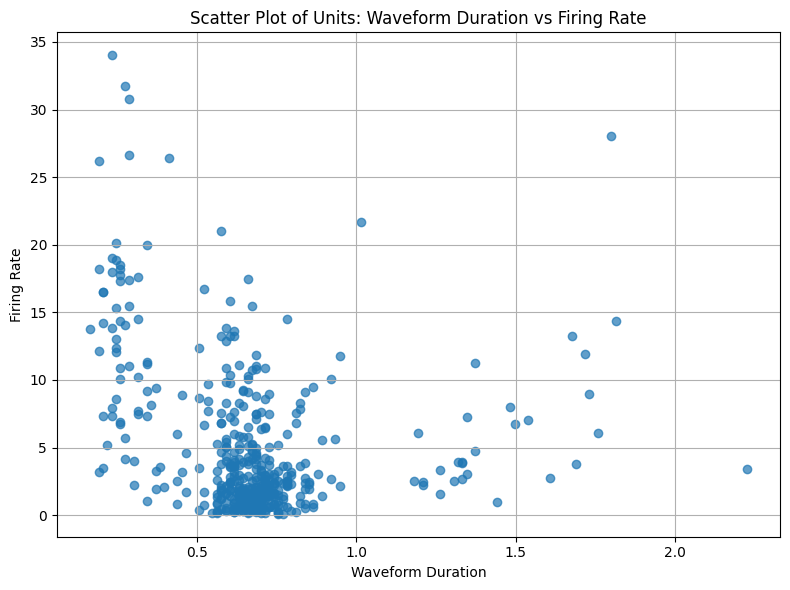

In [41]:

features = visual_units[['firing_rate', 'waveform_duration']].dropna()

plt.figure(figsize=(8, 6))
plt.scatter(features['waveform_duration'], features['firing_rate'], alpha=0.7)
plt.xlabel('Waveform Duration')
plt.ylabel('Firing Rate')
plt.title('Scatter Plot of Units: Waveform Duration vs Firing Rate')
plt.grid(True)
plt.tight_layout()
plt.show()     

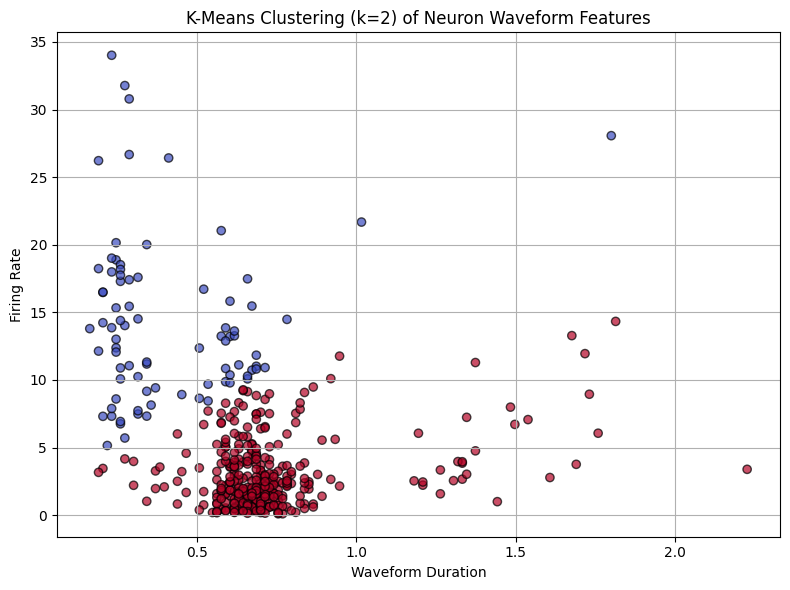

In [42]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = visual_units[['waveform_duration', 'firing_rate']].dropna()
unit_ids = features.index
X = features.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

mean_0 = X[clusters == 0].mean(axis=0)
mean_1 = X[clusters == 1].mean(axis=0)

# FS: shorter waveform, higher firing rate
if (mean_0[0] < mean_1[0]) and (mean_0[1] > mean_1[1]):
    fs_cluster = 0
    rs_cluster = 1
else:
    fs_cluster = 1
    rs_cluster = 0

FS_neurons = unit_ids[clusters == fs_cluster].tolist()
RS_neurons = unit_ids[clusters == rs_cluster].tolist()

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('Waveform Duration')
plt.ylabel('Firing Rate')
plt.title('K-Means Clustering (k=2) of Neuron Waveform Features')
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
natural_scenes_count = oursession.stimulus_presentations[
    oursession.stimulus_presentations['stimulus_name'] == 'natural_scenes'].shape[0]

print("Number of 'natural_scenes' presentations:", natural_scenes_count) #Indeed we have 118 natural_scenes images, each presented 50 times,
 #so we had to have 50*118= 5900 presentations of natural_scenes in general for each session - question: from where the remaining 50 came from? 
#( from frames '-1':grey screen)

Number of 'natural_scenes' presentations: 5950


Classification Report:
              precision    recall  f1-score   support

          RS       1.00      1.00      1.00        77
          FS       1.00      1.00      1.00        12

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89

Confusion Matrix:
[[77  0]
 [ 0 12]]


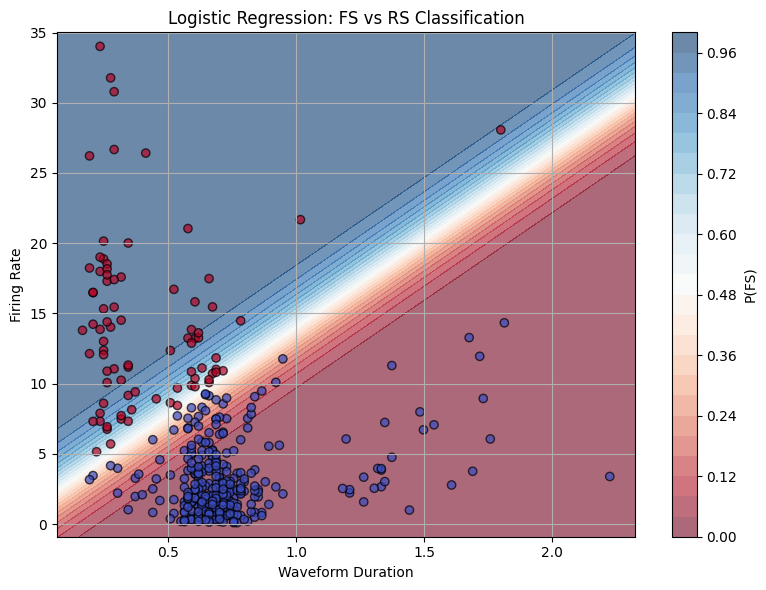

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

features = visual_units[['waveform_duration', 'firing_rate']].dropna()
unit_ids = features.index  # Make sure this is a Pandas Index
labels = np.isin(unit_ids, FS_neurons).astype(int)  # 1 = FS, 0 = RS
X = features.values

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

#  Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train logistic regression
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

# evaluate model
y_pred = clf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['RS', 'FS']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)
probs = clf.predict_proba(grid_scaled)[:, 1].reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, 25, cmap="RdBu", alpha=0.6)
plt.colorbar(label="P(FS)")
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel("Waveform Duration")
plt.ylabel("Firing Rate")
plt.title("Logistic Regression: FS vs RS Classification")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
natural_scenes_indices = oursession.get_stimulus_epochs()[
    oursession.get_stimulus_epochs()['stimulus_name'] == 'natural_scenes'
].index.tolist()
natural_scenes_indices

[19, 21, 27]

In [46]:
len(visual_units)

443

 Code to Update FS/RS Lists with 95% Confidence

In [47]:
# get predicted probabilities for the full dataset
X_all_scaled = scaler.transform(X)
probs = clf.predict_proba(X_all_scaled)[:, 1]  # P(FS)

# create masks
fs_mask = probs >= 0.95
rs_mask = probs <= 0.05

# map masks to unit IDs
confident_FS_neurons = unit_ids[fs_mask].tolist()
confident_RS_neurons = unit_ids[rs_mask].tolist()

print(f"Confident FS neurons (P(FS) ≥ 0.95): {len(confident_FS_neurons)}")
print(f"Confident RS neurons (P(FS) ≤ 0.05): {len(confident_RS_neurons)}")

Confident FS neurons (P(FS) ≥ 0.95): 49
Confident RS neurons (P(FS) ≤ 0.05): 309


In [48]:
ns_scenes_ids=oursession.get_stimulus_table('natural_scenes').index.values
confident_rs_spk=oursession.presentationwise_spike_times(stimulus_presentation_ids=ns_scenes_ids, unit_ids= confident_RS_neurons)
confident_rs_spk.head(10)    #confident_rs_spk - means confident RS neurons' presentation wise spike times 

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5909.795038,51355,951108531,0.000591
5909.797766,51355,951113280,0.003320
5909.803366,51355,951112914,0.008920
5909.805297,51355,951098560,0.010851
5909.806454,51355,951092912,0.012008
5909.807021,51355,951093094,0.012574
5909.808905,51355,951109137,0.014458
5909.811957,51355,951103768,0.017511
5909.818299,51355,951112914,0.023853


In [49]:
oursession.get_stimulus_epochs()[oursession.get_stimulus_epochs()['stimulus_name']=='natural_scenes']#there are spontaneous stimuli in betweem each type

,start_time,stop_time,duration,stimulus_name,stimulus_block
19,5909.794447,6390.196047,480.401600,natural_scenes,9.0
21,6690.446947,7170.848457,480.401510,natural_scenes,10.0
27,8041.576237,8569.517485,527.941248,natural_scenes,13.0


In [50]:
oursession.get_stimulus_epochs().iloc[[18, 20, 26]]  #spontaneous stimuli epochs before natural_scenes

,start_time,stop_time,duration,stimulus_name,stimulus_block
18,5879.769367,5909.794447,30.02508,spontaneous,null
20,6390.196047,6690.446947,300.25090,spontaneous,null
26,8011.551127,8041.576237,30.02511,spontaneous,null


To focus our analysis on RS neurons that clearly respond to visual stimuli and show temporal changes, we apply the following filtering steps:
Response Strength Calculation
 For each neuron, we compute: 
response_strength = firing_rate_during_first_ns - firing_rate_during_spontaneous
If response_strength > 0, the neuron is considered visually responsive.
Avoiding Adaptation Bias


We use firing rates only from the first natural scene presentation in each epoch (NS epochs: 19, 21, 27).


This avoids confounding effects of neural adaptation.


Resting Baseline Estimation


Spontaneous firing rate is computed using only the last half of each spontaneous block, to better reflect a neuron's resting state.


Filtering Criterion


Units with negative response strength in all three are discarded as unresponsive.

In [51]:
# For each spontaneous block, this code finds the first natural scenes stimulus_presentation_id 
# that has RS spikes occurring after the block's end time, and stores those IDs in a list.

spont_stop_times = [5909.794447, 6690.446947, 8041.576237]
first_ns_ids_after_spont = []

for stop_time in spont_stop_times:
    filtered = confident_rs_spk[confident_rs_spk.index >= stop_time]
    if not filtered.empty:
        first_id = filtered.iloc[0]['stimulus_presentation_id']
        first_ns_ids_after_spont.append(first_id)
    else:
        first_ns_ids_after_spont.append(None)
first_ns_ids_after_spont = [int(x) for x in first_ns_ids_after_spont if x is not None]
first_ns_ids_after_spont

[51355, 53276, 66119]

In [52]:
# Get spikes from the first natural scene presentation only (ID: 51355)
first_ns_spk_1 = confident_rs_spk[confident_rs_spk['stimulus_presentation_id'] == 51355]
# Define duration of the first natural scene presentation
first_ns_duration_1 = first_ns_spk_1['time_since_stimulus_presentation_onset'].max()
# Count spikes per unit
first_ns_counts_1 = first_ns_spk_1['unit_id'].value_counts()
# Compute firing rates (Hz)
first_ns_firing_rate_dict_1 = (first_ns_counts_1 / first_ns_duration_1).to_dict()

# repeat for 2nd spontaneous block (ID: 53276) ---
first_ns_spk_2 = confident_rs_spk[confident_rs_spk['stimulus_presentation_id'] == 53276]
first_ns_duration_2 = first_ns_spk_2['time_since_stimulus_presentation_onset'].max()
first_ns_counts_2 = first_ns_spk_2['unit_id'].value_counts()
first_ns_firing_rate_dict_2 = (first_ns_counts_2 / first_ns_duration_2).to_dict()

# repeat for 3rd spontaneous block (ID: 66119) ---
first_ns_spk_3 = confident_rs_spk[confident_rs_spk['stimulus_presentation_id'] == 66119]
first_ns_duration_3 = first_ns_spk_3['time_since_stimulus_presentation_onset'].max()
first_ns_counts_3 = first_ns_spk_3['unit_id'].value_counts()
first_ns_firing_rate_dict_3 = (first_ns_counts_3 / first_ns_duration_3).to_dict()

In [53]:
# get spontaneous stimulus presentation IDs
spontaneous_scenes_ids = oursession.get_stimulus_table('spontaneous').index.values

# get spike times for RS units during spontaneous blocks
vis_spontaneous_before_spk = oursession.presentationwise_spike_times(
    stimulus_presentation_ids=spontaneous_scenes_ids,
    unit_ids=confident_RS_neurons
)

# define the duration of the three spontaneous stimulus blocks
duration_1 = 30.02508   # in seconds
duration_2 = 300.25090
duration_3 = 30.02511
# filter the last half of spike times for the 3 spontaneous blocks before natural scenes
spontaneous_spikes_before_1 = vis_spontaneous_before_spk[
    (vis_spontaneous_before_spk.index >= 5879.769367 + duration_1 / 2) &
    (vis_spontaneous_before_spk.index <= 5909.794447)
]
spontaneous_spikes_before_2 = vis_spontaneous_before_spk[
    (vis_spontaneous_before_spk.index >= 6390.196047 + duration_2 / 2) &
    (vis_spontaneous_before_spk.index <= 6690.446947)
]

spontaneous_spikes_before_3 = vis_spontaneous_before_spk[
    (vis_spontaneous_before_spk.index >= 8011.551127 + duration_3 / 2) &
    (vis_spontaneous_before_spk.index <= 8041.576237)
]

In [54]:
# count spikes per unit_id
spike_counts_1 = spontaneous_spikes_before_1['unit_id'].value_counts()
spike_counts_2 = spontaneous_spikes_before_2['unit_id'].value_counts()
spike_counts_3 = spontaneous_spikes_before_3['unit_id'].value_counts()

# compute firing rate per unit (spikes / duration)
avg_firing_rate_dict_spontaneous_before_1 = (spike_counts_1 / duration_1).to_dict()
avg_firing_rate_dict_spontaneous_before_2 = (spike_counts_2 / duration_2).to_dict()
avg_firing_rate_dict_spontaneous_before_3 = (spike_counts_3 / duration_3).to_dict()

print(len(avg_firing_rate_dict_spontaneous_before_1))
print(len(avg_firing_rate_dict_spontaneous_before_2))
print(len(avg_firing_rate_dict_spontaneous_before_3))

269
308
290


In [55]:
# compute difference for units in both dictionaries
firing_rate_diff_dict_1 = {}
firing_rate_diff_dict_2 = {}
firing_rate_diff_dict_3 = {}

for unit_id in avg_firing_rate_dict_spontaneous_before_1:
    spontaneous_rate = avg_firing_rate_dict_spontaneous_before_1[unit_id]
    ns_rate = first_ns_firing_rate_dict_1.get(unit_id, 0)  # 0 if neuron didn't fire during NS
    firing_rate_diff_dict_1[unit_id] = ns_rate - spontaneous_rate

for unit_id in avg_firing_rate_dict_spontaneous_before_2:
    spontaneous_rate = avg_firing_rate_dict_spontaneous_before_2[unit_id]
    ns_rate = first_ns_firing_rate_dict_2.get(unit_id, 0)
    firing_rate_diff_dict_2[unit_id] = ns_rate - spontaneous_rate

for unit_id in avg_firing_rate_dict_spontaneous_before_3:
    spontaneous_rate = avg_firing_rate_dict_spontaneous_before_3[unit_id]
    ns_rate = first_ns_firing_rate_dict_3.get(unit_id, 0)
    firing_rate_diff_dict_3[unit_id] = ns_rate - spontaneous_rate

if firing_rate_diff is:
Positive → neuron fired more during natural scenes
Negative → neuron was quieter during visual stimulation
We see that this difference is positive for most neurons. 

We drop the units that fired less during the first presentation of natural scene after spontaneous stimulus, because they dont react to natural scenes. Those are the units that have negative values in all three firing_rate_diff_dict s. They clearly dont react much to natural stimuli. We delete them from confident_RS_neurons. Our final list of selected neurons is RS_units_filtered

In [56]:
# get the list of RS unit_ids
# define function to check if a unit has negative diff in all 3 blocks
def is_unresponsive(unit_id):
    return (
        firing_rate_diff_dict_1.get(unit_id, 0) <0 and
        firing_rate_diff_dict_2.get(unit_id, 0) <0 and
        firing_rate_diff_dict_3.get(unit_id, 0) <0
    )

# filter out unresponsive units
unresponsive_ids = [uid for uid in confident_RS_neurons if is_unresponsive(uid)]

# drop them from RS_units
RS_units_filtered = [uid for uid in confident_RS_neurons if uid not in unresponsive_ids]

print(f"Original RS units: {len(confident_RS_neurons)}")
print(f"Unresponsive RS units removed: {len(unresponsive_ids)}")
print(f"Remaining RS units: {len(RS_units_filtered)}")

Original RS units: 309
Unresponsive RS units removed: 60
Remaining RS units: 249


# Image Selection (I)

In [57]:
stimulus_presentations = oursession.stimulus_presentations
spikes = confident_rs_spk

def get_spike_times(spikes_df, unit_id):
    unit_df = spikes_df[spikes_df['unit_id'] == unit_id]
    for col in ['spike_time', 'time', 'times']:
        if col in unit_df.columns:
            return unit_df[col].values
    return unit_df.index.values


In [58]:
def compute_rates(spike_times, starts, stops):

    sorted_spikes = np.sort(spike_times)
    left_idx = np.searchsorted(sorted_spikes, starts, side='left')
    right_idx = np.searchsorted(sorted_spikes, stops, side='left')
    counts = right_idx - left_idx
    durations = stops - starts
    return counts / durations

In [59]:
stimulus_presentations['frame'] = pd.to_numeric(
    stimulus_presentations['frame'], errors='coerce'
)
stimulus_presentations = stimulus_presentations.dropna(subset=['frame'])
stimulus_presentations['frame'] = stimulus_presentations['frame'].astype(int)

frame_counts = stimulus_presentations['frame'].value_counts()
valid_frames = frame_counts[frame_counts >= 20].index

In [60]:

rs_responsive_df = oursession.units.loc[ RS_units_filtered ].copy()

print(f"Responsive RS units DataFrame has {len(rs_responsive_df)} rows")
rs_responsive_df.head()

Responsive RS units DataFrame has 249 rows


,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,L_ratio,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951092398,0.304186,70.886595,0.004767,261,141.35,3.613471,2.146108,0.452192,36.292579,0.028889,...,394.0,VISam,7754.0,1064.0,7462.0,probeA,See electrode locations,29999.965974,1249.998582,True
951092410,0.374989,134.377230,0.004461,262,98.17,5.223972,3.611337,0.019273,65.489417,0.002606,...,394.0,VISam,7751.0,1055.0,7463.0,probeA,See electrode locations,29999.965974,1249.998582,True
951092539,0.285255,120.924765,0.001802,272,140.03,6.774371,0.881015,0.323840,73.080752,0.000145,...,394.0,VISam,7728.0,974.0,7475.0,probeA,See electrode locations,29999.965974,1249.998582,True
951092567,0.401508,58.976190,0.054928,274,276.50,4.591916,1.857259,0.166561,63.611400,0.001913,...,394.0,VISam,7726.0,965.0,7476.0,probeA,See electrode locations,29999.965974,1249.998582,True
951094440,0.378298,117.277290,0.021791,418,247.01,4.753833,1.584505,0.085815,51.286532,0.004278,...,394.0,VISam,7713.0,920.0,7483.0,probeA,See electrode locations,29999.965974,1249.998582,True


In [61]:
from scipy.stats import linregress, spearmanr

delta_rate_scores = []
slope_scores = []
correlation_scores = []
fano_scores = []


In [62]:
for frame_num in valid_frames:
    frame_df = stimulus_presentations[stimulus_presentations['frame'] == frame_num]
    sorted_df = frame_df.sort_values(by='start_time')
    windows = sorted_df[['start_time', 'stop_time']].values
    trial_idx = np.arange(len(windows))

    delta_list, slope_list, corr_list, fano_list = [], [], [], []

    for unit_id in rs_responsive_df.index:
        #   sort spike times once per unit
        st_times = get_spike_times(spikes, unit_id)
        rates = compute_rates(
            st_times,
            windows[:, 0],
            windows[:, 1]
        )
        if rates.size < 10 or rates.mean() == 0:
            continue

        #  metrics
        delta_list.append(rates[:10].mean() - rates[-10:].mean())
        slope, _, _, _, _ = linregress(trial_idx, rates)
        slope_list.append(slope)
        corr_list.append(spearmanr(trial_idx, rates).correlation)
        fano_list.append(rates.var() / rates.mean())

    if delta_list:
        delta_rate_scores.append((frame_num, np.mean(delta_list)))
    if slope_list:
        slope_scores.append((frame_num, np.mean(slope_list)))
    if corr_list:
        correlation_scores.append((frame_num, np.mean(corr_list)))
    if fano_list:
        fano_scores.append((frame_num, np.mean(fano_list)))

In [63]:
metrics = {
    'delta_rate': dict(delta_rate_scores),
    'slope': dict(slope_scores),
    'spearman_corr': dict(correlation_scores),
    'fano': dict(fano_scores),
}
results = pd.DataFrame.from_dict(metrics).reset_index().rename(columns={'index': 'frame'})
print(results)


     frame  delta_rate     slope  spearman_corr      fano
0        0   -3.040102  0.029504       0.198879  6.914146
1       74   -3.197340  0.031068       0.205485  7.475152
2       86   -3.326158  0.033042       0.199157  8.251665
3       85   -2.946105  0.029856       0.199640  7.207902
4       84   -3.190787  0.029094       0.187137  6.868998
..     ...         ...       ...            ...       ...
114     34   -3.361830  0.029537       0.202255  6.941612
115     33   -3.202358  0.028482       0.186349  6.895874
116     32   -2.953611  0.027306       0.179604  7.272654
117    117   -3.031608  0.027843       0.190823  7.034321
118     -1    0.469640 -0.016136      -0.035999  6.379811

[119 rows x 5 columns]


In [64]:
df_delta = pd.DataFrame(delta_rate_scores, columns=["frame", "delta_firing_rate"])
df_slope = pd.DataFrame(slope_scores,   columns=["frame", "slope"])
df_corr  = pd.DataFrame(correlation_scores, columns=["frame", "spearman_r"])
df_fano  = pd.DataFrame(fano_scores,    columns=["frame", "fano_factor"])


# merge first
df_combined_raw = (
    df_delta
    .merge(df_slope, on="frame")
    .merge(df_corr, on="frame")
    .merge(df_fano, on="frame")
)

# aggregate over frames
df_combined = df_combined_raw.groupby("frame").mean(numeric_only=True).reset_index()
# drop frame -1 if needed
df_combined = df_combined[df_combined['frame'] >= 0]

# rank each metric (higher ΔFR → better → rank=1; others lower → better → rank=1)
df_combined["rank_delta"] = df_combined["delta_firing_rate"].rank(ascending=False)
df_combined["rank_slope"] = df_combined["slope"].rank(ascending=True)
df_combined["rank_corr"]  = df_combined["spearman_r"].rank(ascending=True)
df_combined["rank_fano"]  = df_combined["fano_factor"].rank(ascending=True)

# composite score = sum of ranks
df_combined["total_rank"] = (
      df_combined["rank_delta"]
    + df_combined["rank_slope"]
    + df_combined["rank_corr"]
    + df_combined["rank_fano"]
)

# sort by composite rank
df_sorted = df_combined.sort_values("total_rank")

df_summary = (
    df_sorted.head(10)
      .assign(type="Most Adaptive")
    .append(
      df_sorted.tail(10)
        .assign(type="Least Adaptive"),
      ignore_index=True
    )
    .reset_index(drop=True)
)

df_summary

/var/folders/by/0_ptx__10z3g6s8mcq130bzh0000gn/T/ipykernel_78026/2069130567.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  .append(


,frame,delta_firing_rate,slope,spearman_r,fano_factor,rank_delta,rank_slope,rank_corr,rank_fano,total_rank,type
0,20,-2.894651,0.022255,0.161538,6.848915,21.0,5.0,7.0,1.0,34.0,Most Adaptive
1,81,-2.294740,0.015866,0.142363,7.293435,1.0,1.0,1.0,47.0,50.0,Most Adaptive
2,111,-2.787705,0.022729,0.159710,7.218863,11.0,6.0,6.0,34.0,57.0,Most Adaptive
3,37,-2.539906,0.023892,0.181684,7.070130,5.0,8.0,32.0,14.0,59.0,Most Adaptive
4,88,-2.358372,0.021507,0.185196,7.086922,2.0,4.0,43.0,19.0,68.0,Most Adaptive
5,36,-2.924316,0.023319,0.167141,7.107358,28.0,7.0,11.0,22.0,68.0,Most Adaptive
6,63,-2.653974,0.024108,0.186282,7.022228,7.0,11.0,46.0,9.0,73.0,Most Adaptive
7,40,-2.687907,0.026109,0.184242,7.071167,8.0,32.0,37.0,15.0,92.0,Most Adaptive
8,15,-2.878266,0.024100,0.186351,7.170412,17.0,10.0,48.0,27.0,102.0,Most Adaptive
9,62,-2.416238,0.021056,0.162462,7.514156,3.0,3.0,9.0,89.0,104.0,Most Adaptive


In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition    import PCA

metrics = ['delta_firing_rate','slope','spearman_r','fano_factor']

X  = df_combined[metrics].values
Xz = StandardScaler().fit_transform(X)

pca = PCA(n_components=1)
pc1 = pca.fit_transform(Xz).ravel()

#  flip sign so higher=more adaptive and sort
df_combined['pc1_adapt'] = -pc1  
print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of variance")

df_pca = df_combined.sort_values('pc1_adapt', ascending=False)

df_pca_summary = pd.concat([
    df_pca.head(10).assign(type='Most Adaptive'),
    df_pca.tail(10).assign(type='Least Adaptive'),
], ignore_index=True).reset_index(drop=True)

df_pca_summary


PC1 explains 55.1% of variance


,frame,delta_firing_rate,slope,spearman_r,fano_factor,rank_delta,rank_slope,rank_corr,rank_fano,total_rank,pc1_adapt,type
0,81,-2.294740,0.015866,0.142363,7.293435,1.0,1.0,1.0,47.0,50.0,5.273330,Most Adaptive
1,62,-2.416238,0.021056,0.162462,7.514156,3.0,3.0,9.0,89.0,104.0,3.400493,Most Adaptive
2,114,-2.897548,0.019615,0.155762,7.584179,23.0,2.0,4.0,96.0,125.0,2.988773,Most Adaptive
3,88,-2.358372,0.021507,0.185196,7.086922,2.0,4.0,43.0,19.0,68.0,2.925857,Most Adaptive
4,20,-2.894651,0.022255,0.161538,6.848915,21.0,5.0,7.0,1.0,34.0,2.706151,Most Adaptive
5,111,-2.787705,0.022729,0.159710,7.218863,11.0,6.0,6.0,34.0,57.0,2.682904,Most Adaptive
6,37,-2.539906,0.023892,0.181684,7.070130,5.0,8.0,32.0,14.0,59.0,2.299745,Most Adaptive
7,36,-2.924316,0.023319,0.167141,7.107358,28.0,7.0,11.0,22.0,68.0,2.162442,Most Adaptive
8,63,-2.653974,0.024108,0.186282,7.022228,7.0,11.0,46.0,9.0,73.0,1.942115,Most Adaptive
9,35,-3.220540,0.024745,0.147966,7.375272,79.0,14.0,2.0,63.0,158.0,1.852749,Most Adaptive


In [66]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Xz = StandardScaler().fit_transform(df_combined[metrics])
best_k, best_sil = None, -1
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=0).fit(Xz)
    sil = silhouette_score(Xz, km.labels_)
    if sil > best_sil:
        best_k, best_sil = k, sil
print(f"Best k = {best_k} (silhouette = {best_sil:.2f})")


Best k = 2 (silhouette = 0.29)


In [67]:
km = KMeans(n_clusters=best_k, random_state=0).fit(Xz)
df_combined['cluster'] = km.labels_
df_combined.groupby('cluster')[metrics + ['pc1_adapt']].mean()


,delta_firing_rate,slope,spearman_r,fano_factor,pc1_adapt
cluster,,,,,
0,-2.951836,0.025872,0.179904,7.291255,1.171092
1,-3.269776,0.031479,0.202849,7.436021,-1.171092


<Axes: xlabel='cluster', ylabel='pc1_adapt'>

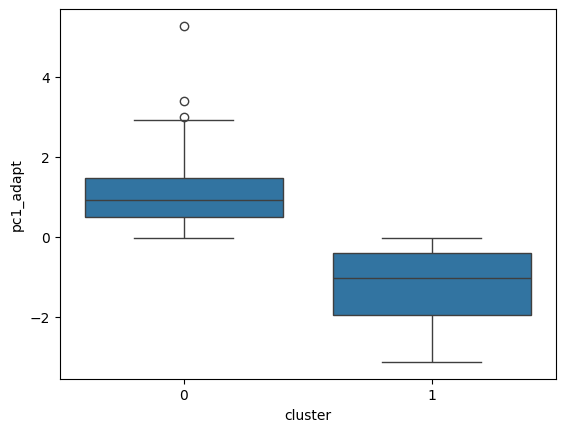

In [68]:
import seaborn as sns
sns.boxplot(x='cluster', y='pc1_adapt', data=df_combined)

In [69]:
import cv2
from scipy.fft import fft2, fftshift

top10    = df_combined.nlargest(10, 'pc1_adapt')['frame'].astype(int).tolist()
bottom10 = df_combined.nsmallest(10, 'pc1_adapt')['frame'].astype(int).tolist()
selected = top10 + bottom10
top_set  = set(top10)

# openCV based features
features_cv = []
for frame_id in selected:
    img = cache.get_natural_scene_template(frame_id)

    # normalize , convert to uint8
    img_u8 = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

    # brightness & contrast
    mean_val, std_val = cv2.meanStdDev(img_u8)
    mean_intensity    = float(mean_val)
    contrast          = float(std_val)

    # edge density w sobel
    gx = cv2.Sobel(img_u8, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img_u8, cv2.CV_64F, 0, 1, ksize=3)
    edge_map     = cv2.magnitude(gx, gy)
    edge_density = float((edge_map > edge_map.mean()).sum() / edge_map.size)

    # spectral slope (radial FFT)
    F      = np.abs(fftshift(fft2(img.astype(float))))
    y, x   = np.indices(F.shape)
    cy, cx = np.array(F.shape) / 2
    r      = np.hypot(x-cx, y-cy).astype(int)
    tbin   = np.bincount(r.ravel(), F.ravel())
    nr     = np.bincount(r.ravel())
    radial = tbin / nr
    freqs  = np.arange(len(radial))
    mask   = freqs > 0
    slope, _ = np.polyfit(np.log(freqs[mask]), np.log(radial[mask]), 1)

    features_cv.append({
        'frame':          frame_id,
        'type':           'Most' if frame_id in top_set else 'Least',
        'mean_intensity': mean_intensity,
        'contrast':       contrast,
        'edge_density':   edge_density,
        'spectral_slope': float(slope),
    })

df_feat_cv = pd.DataFrame(features_cv, columns=[
    'frame', 'type', 'mean_intensity', 'contrast', 'edge_density', 'spectral_slope'
])
print(df_feat_cv)

    frame   type  mean_intensity   contrast  edge_density  spectral_slope
0      81   Most       95.084979  81.673905      0.302313       -1.493829
1      62   Most      103.918334  59.005013      0.379226       -1.415079
2     114   Most      124.448190  77.452301      0.377482       -1.549667
3      88   Most      112.286318  62.551091      0.355574       -1.488530
4      20   Most      125.703541  74.693058      0.330830       -1.616779
5     111   Most      121.706000  57.501863      0.362237       -1.532866
6      37   Most      120.423958  55.679742      0.342976       -1.639152
7      36   Most      124.931469  66.086026      0.387852       -1.588567
8      63   Most      120.433488  55.248628      0.375641       -1.222690
9      35   Most      114.862801  77.008078      0.302959       -1.685120
10     18  Least      125.935272  81.722256      0.196960       -1.774620
11    107  Least      124.736973  64.825924      0.354786       -1.473848
12     26  Least      125.205957  69.9

In [70]:
summary_cv = df_feat_cv.groupby('type').agg({
    'mean_intensity':  ['mean','std'],
    'contrast':        ['mean','std'],
    'edge_density':    ['mean','std'],
    'spectral_slope':  ['mean','std']
})
print(summary_cv)

      mean_intensity              contrast            edge_density            \
                mean        std       mean        std         mean       std   
type                                                                           
Least     117.228202  12.957941  72.076478   5.840842     0.317993  0.058610   
Most      116.379908  10.078214  66.689970  10.132254     0.351709  0.031189   

      spectral_slope            
                mean       std  
type                            
Least      -1.633820  0.103008  
Most       -1.523228  0.132308  


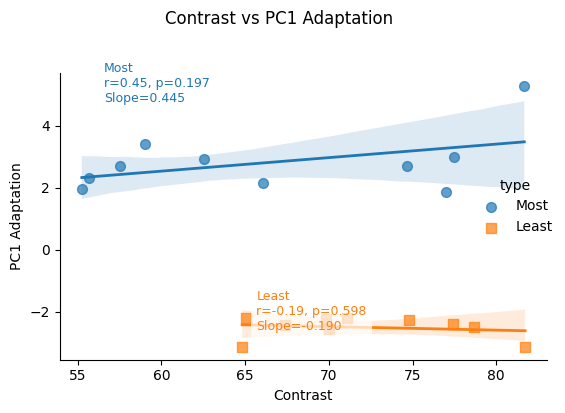

In [71]:
from scipy.stats import pearsonr, spearmanr

df_plot = df_feat_cv.merge(df_combined[['frame', 'pc1_adapt']], on='frame')

# Single-feature plot for contrast
feat = 'contrast'

g = sns.lmplot(
    x=feat,
    y='pc1_adapt',
    data=df_plot,
    hue='type',
    palette={'Most': 'tab:blue', 'Least': 'tab:orange'},
    markers=['o', 's'],
    height=4,
    aspect=1.2,
    scatter_kws={'s': 50, 'alpha': 0.7},
    line_kws={'lw': 2}
)

g.set_axis_labels("Contrast", "PC1 Adaptation")
g.fig.suptitle("Contrast vs PC1 Adaptation", y=1.02)
ax = g.ax

# Add correlation and slope text for each group
for i, label in enumerate(['Most', 'Least']):
    sub = df_plot[df_plot['type'] == label]
    r_p, p_p = pearsonr(sub[feat], sub['pc1_adapt'])
    r_s, p_s = spearmanr(sub[feat], sub['pc1_adapt'])

    x_txt = sub[feat].min() + 0.05 * (sub[feat].max() - sub[feat].min())
    y_txt = sub['pc1_adapt'].min() + (0.85 - 0.25 * i) * (sub['pc1_adapt'].max() - sub['pc1_adapt'].min())

    ax.text(
        x_txt, y_txt,
        f"{label}\nr={r_p:.2f}, p={p_p:.3f}\nSlope={sub[feat].corr(sub['pc1_adapt']):.3f}",
        color='tab:blue' if label == 'Most' else 'tab:orange',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

plt.tight_layout()
plt.show()


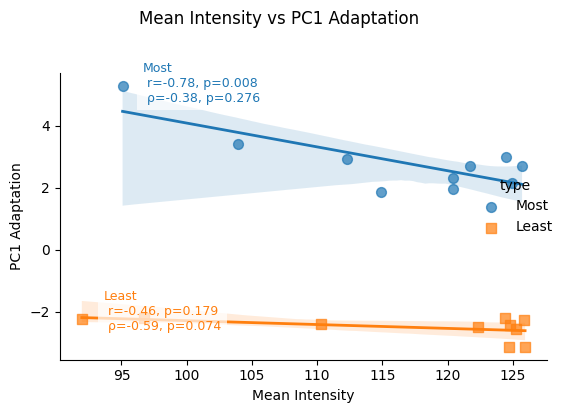

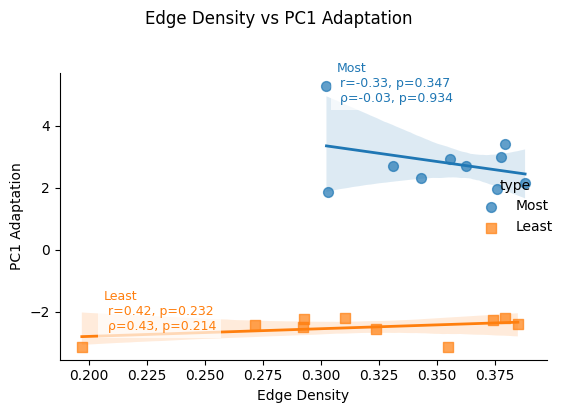

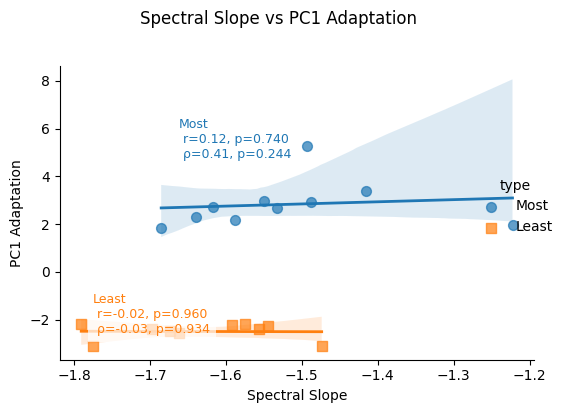

In [72]:

from scipy.stats import pearsonr, spearmanr

df_plot = df_feat_cv.merge(df_combined[['frame', 'pc1_adapt']], on='frame')
features = ['mean_intensity', 'edge_density', 'spectral_slope']

for feat in features:
    g = sns.lmplot(
        x=feat,
        y='pc1_adapt',
        data=df_plot,
        hue='type',
        palette={'Most': 'tab:blue', 'Least': 'tab:orange'},
        markers=['o', 's'],
        height=4,
        aspect=1.2,
        scatter_kws={'s': 50, 'alpha': 0.7},
        line_kws={'lw': 2}
    )

    g.set_axis_labels(feat.replace('_', ' ').title(), 'PC1 Adaptation')
    g.fig.suptitle(f"{feat.replace('_', ' ').title()} vs PC1 Adaptation", y=1.02)
    ax = g.ax

    for i, label in enumerate(['Most', 'Least']):
        sub = df_plot[df_plot['type'] == label]
        r_p, p_p = pearsonr(sub[feat], sub['pc1_adapt'])
        r_s, p_s = spearmanr(sub[feat], sub['pc1_adapt'])

        x_txt = sub[feat].min() + 0.05 * (sub[feat].max() - sub[feat].min())
        y_txt = sub['pc1_adapt'].min() + (0.85 - 0.25 * i) * (sub['pc1_adapt'].max() - sub['pc1_adapt'].min())

        ax.text(
            x_txt, y_txt,
            f"{label}\n r={r_p:.2f}, p={p_p:.3f}\n ρ={r_s:.2f}, p={p_s:.3f}",
            color='tab:blue' if label == 'Most' else 'tab:orange',
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    plt.tight_layout()
    plt.show()


# Image selection (II)

Image Selection Strategy: Presentation Timing
Goal: Explore how the temporal structure of image presentation affects neural adaptation.
Method:
1) 118 images, each shown 50 times in random order (5900 total + ‘grey screen’ shown 50 times (frame ‘-1’) but we exclude it from our analysis).
2) For each image, track when it was shown across the session.
3) Calculate spacing between presentations to detect patterns.
Identified Patterns:
Uniform – evenly spaced across time
Increasing – more frequent later
Decreasing – more frequent early
Approach:
            Select one image that fits best for each pattern.
            Analyze how neuron responses change over repeated presentations for these selected images.
Key Question:
           Which presentation pattern drives stronger or weaker adaptation?

In [73]:
oursession.get_stimulus_epochs()[oursession.get_stimulus_epochs()['stimulus_name']=='natural_scenes']

,start_time,stop_time,duration,stimulus_name,stimulus_block
19,5909.794447,6390.196047,480.401600,natural_scenes,9.0
21,6690.446947,7170.848457,480.401510,natural_scenes,10.0
27,8041.576237,8569.517485,527.941248,natural_scenes,13.0


frame = -1 indicates a non-image presentation during a natural scenes session. These are:

Blank screen periods
frame = -1 is used to mark the gray screen shown between image presentations, often called interstimulus intervals (ISIs).

No natural scene is shown during these periods — just a constant luminance screen. We exclude this frame from our analysis

In [74]:
len(oursession.get_stimulus_table()[oursession.get_stimulus_table()['frame']==-1]) #we found out from where the rest 50 stimuli of 5950 (should have
#been 5900 since 118*50=5900) came from - they came from grey screens . we further exclude this -1 frame from our analysis

50

In [75]:
# Create a dictionary: key = frame (image ID), value = list of stimulus_presentation_ids
frame_to_presentations = oursession.get_stimulus_table('natural_scenes').groupby('frame').apply(lambda g: list(g.index)).to_dict()

To find the frame whose presentation times are closest to being evenly spaced (i.e., close to uniform distribution), we'll 
compute the standard deviation of the spacing and choose the one with the smallest std deviation.

Frame with most uniform spacing: 0 (std = 1533.61)


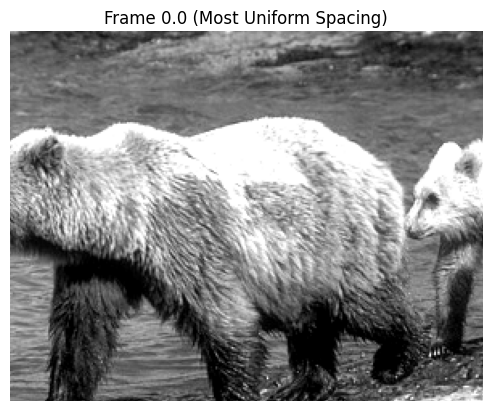

In [76]:

# Compute std deviation of spacing directly, excluding frame = -1
frame_spacing_stats = {
    frame: np.std(np.diff(pres_ids)) 
    for frame, pres_ids in frame_to_presentations.items()
    if frame != -1 and len(pres_ids) > 1
}

# Find the frame with the most uniform spacing
best_frame = min(frame_spacing_stats, key=frame_spacing_stats.get)
best_std = frame_spacing_stats[best_frame]

print(f"Frame with most uniform spacing: {int(best_frame)} (std = {best_std:.2f})")

img = cache.get_natural_scene_template(best_frame)

plt.imshow(img, cmap='gray')
plt.title(f"Frame {best_frame} (Most Uniform Spacing)")
plt.axis('off')
plt.savefig(f"natural_scene_frame_{best_frame}_uniform_spacing.png", bbox_inches='tight', dpi=300)
plt.show()

To find the frame with increasing frequency (i.e. stimulus presentations are spaced further apart early in the session and get closer together 
toward the end), you can look for frames whose inter-presentation intervals (the diffs) decrease over time.

Here's the logic:
For each frame, get the list of stimulus_presentation_ids (already sorted chronologically).

Compute the differences between consecutive presentation IDs.

Fit a line to those differences and find the frame where the slope is most negative, indicating decreasing spacing (i.e., increasing frequency of 
presentation).

Frame with increasing frequency: 18 (slope = -0.94)


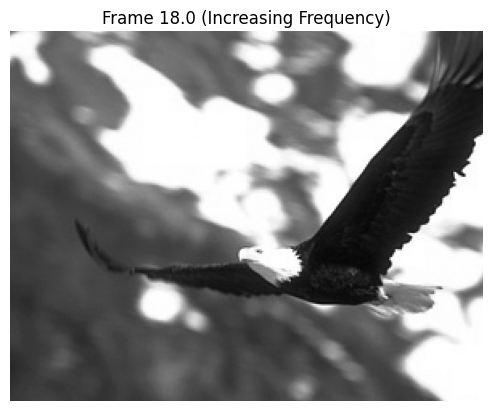

In [77]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

frame_slopes = {}

# Compute slope of spacing between presentations, skipping frame = -1
for frame, pres_ids in frame_to_presentations.items():
    if frame == -1:
        continue  # skip blank screen frames
    if len(pres_ids) > 2:  # Need at least 3 points to fit a trend
        diffs = np.diff(pres_ids)
        x = np.arange(len(diffs))  # time steps: 0, 1, 2, ...
        slope, _, _, _, _ = linregress(x, diffs)
        frame_slopes[frame] = slope

# Find the frame with most negative slope (fastest increase in frequency)
increasing_freq_frame = min(frame_slopes, key=frame_slopes.get)
best_slope = frame_slopes[increasing_freq_frame]

print(f"Frame with increasing frequency: {int(increasing_freq_frame)} (slope = {best_slope:.2f})")

img = cache.get_natural_scene_template(increasing_freq_frame)

plt.imshow(img, cmap='gray')
plt.title(f"Frame {increasing_freq_frame} (Increasing Frequency)")
plt.axis('off')
plt.savefig(f"natural_scene_frame_{increasing_freq_frame}_increasing_freq.png", bbox_inches='tight', dpi=300)
plt.show()

Frame with decreasing frequency: 35 (slope = 19.23)


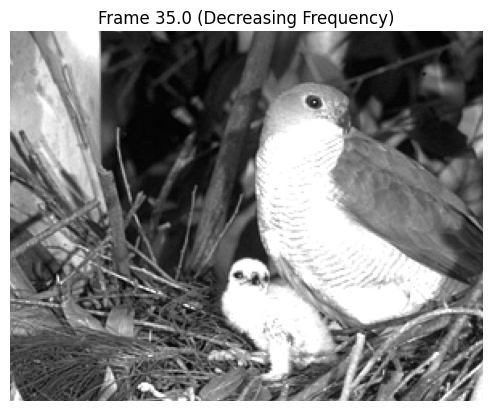

In [78]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

frame_slopes = {}

# Loop over valid frames and compute slope of inter-presentation spacing
for frame, pres_ids in frame_to_presentations.items():
    if frame == -1:
        continue  # skip gray screen
    if len(pres_ids) > 2:
        diffs = np.diff(pres_ids)
        x = np.arange(len(diffs))
        slope, _, _, _, _ = linregress(x, diffs)
        frame_slopes[frame] = slope

# Find the frame with the most positive slope (slowing down → decreasing frequency)
decreasing_freq_frame = max(frame_slopes, key=frame_slopes.get)
worst_slope = frame_slopes[decreasing_freq_frame]

print(f"Frame with decreasing frequency: {int(decreasing_freq_frame)} (slope = {worst_slope:.2f})")

img = cache.get_natural_scene_template(decreasing_freq_frame)

plt.imshow(img, cmap='gray')
plt.title(f"Frame {decreasing_freq_frame} (Decreasing Frequency)")
plt.axis('off')
plt.savefig(f"natural_scene_frame_{decreasing_freq_frame}_decreasing_freq.png", bbox_inches='tight', dpi=300)
plt.show()

# Adaptation efects on selected neurons for frame = 0 (uniform spacing) 

In [79]:
#For now, we perform a linear regression on random image (lets select the image with frame =1) and all RS_units_filtered
# Get the stimulus presentations for natural scenes
natural_scenes_table = oursession.get_stimulus_table('natural_scenes')
# Filter the table to keep only presentations where frame == 1
frame_0_presentations = natural_scenes_table[natural_scenes_table['frame'] == 0]
frame_0_presentations.index 

Int64Index([51553, 51884, 52096, 52166, 52291, 52331, 52389, 52457, 52718,
            52742, 52933, 53124, 53348, 53425, 53442, 53593, 53928, 53957,
            53960, 54165, 54415, 54432, 54434, 54526, 54588, 54638, 54727,
            54767, 54794, 54856, 54858, 55187, 66124, 66219, 66413, 66608,
            66745, 66800, 66857, 66865, 66994, 67076, 67113, 67142, 67162,
            67212, 67354, 67619, 67621, 67822],
           dtype='int64', name='stimulus_presentation_id')

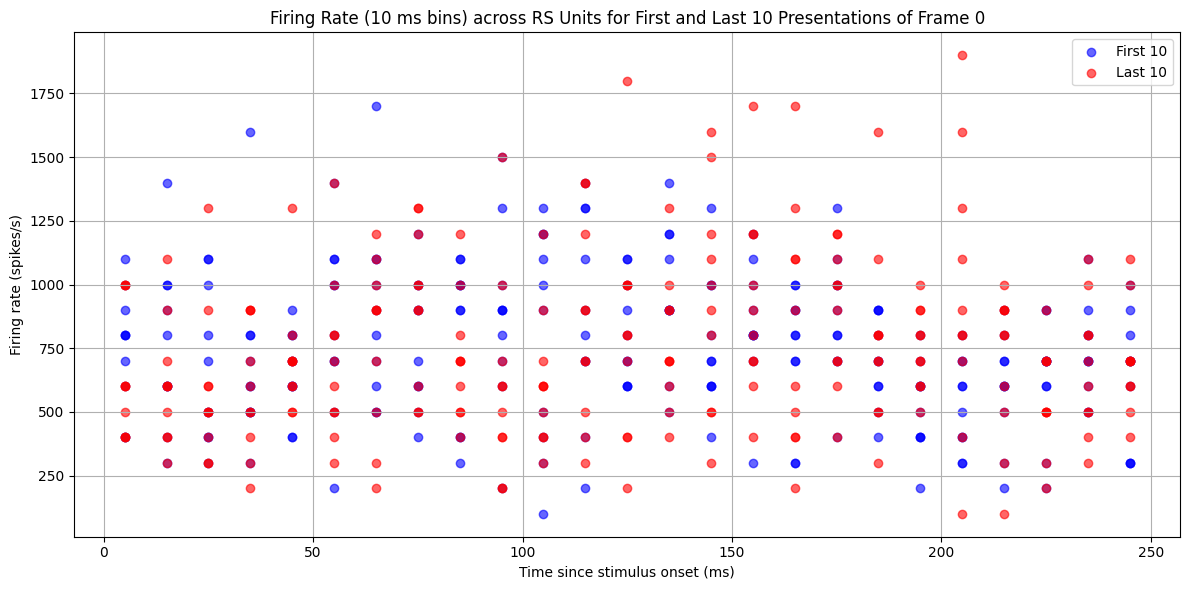

In [80]:


# define binning parameters 
bin_edges = np.arange(0, 0.250 + 0.010, 0.010)  # from 0 to 250 ms in 10 ms steps
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = 0.010  # 10 ms in seconds

# filter spikes to only RS_units_filtered 
rs_spikes = confident_rs_spk[confident_rs_spk['unit_id'].isin(RS_units_filtered)]

# function to compute spike count across all RS units for a given presentation 
def compute_total_firing_rate(pres_id):
    spike_times = rs_spikes[rs_spikes['stimulus_presentation_id'] == pres_id]['time_since_stimulus_presentation_onset']
    counts, _ = np.histogram(spike_times, bins=bin_edges)
    return counts / bin_width  # convert to spikes/sec (firing rate)

# plot all 20 presentations 
plt.figure(figsize=(12, 6))
first10_ids = frame_0_presentations.index[:10].tolist()   
last10_ids = frame_0_presentations.index[-10:].tolist()   

#  proceed with the loop
for i, pres_id in enumerate(first10_ids + last10_ids):
    firing_rate = compute_total_firing_rate(pres_id)
    color = 'blue' if i < 10 else 'red'
    label = 'First 10' if i == 0 else ('Last 10' if i == 10 else None)
    plt.scatter(bin_centers * 1000, firing_rate, color=color, alpha=0.6, label=label)

plt.xlabel("Time since stimulus onset (ms)")
plt.ylabel("Firing rate (spikes/s)")
plt.title("Firing Rate (10 ms bins) across RS Units for First and Last 10 Presentations of Frame 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Interpretation (qualitative)
From visual inspection:

The blue (early) points often appear slightly more spread toward higher spike counts.

The red (late) dots may cluster lower, suggesting possible adaptation (reduced responsiveness over time).

However, there’s high variability — so this needs quantitative validation.

1. Average PSTH curves (smoothed)
Compute and plot the mean spike count per bin across the 10 presentations (first vs. last):

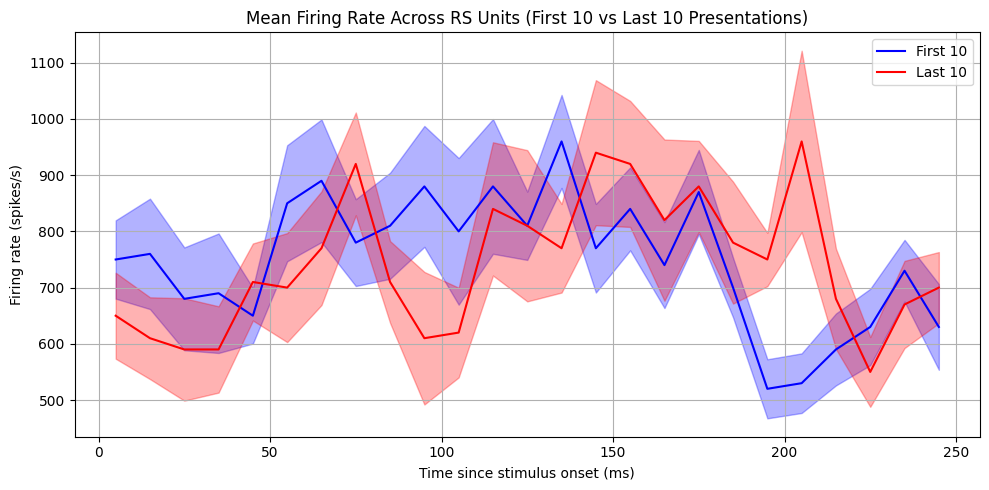

(0.15038112215090665, 0.882481731538518)

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# reuse bin edges and bin centers
bin_edges = np.arange(0, 0.250 + 0.010, 0.010)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = 0.010  # 10 ms

# Filter RS spikes
rs_spikes = confident_rs_spk[confident_rs_spk['unit_id'].isin(RS_units_filtered)]

# Compute binned firing rates for a list of presentation IDs
def get_firing_matrix(pres_ids):
    firing_matrix = []
    for pid in pres_ids:
        spike_times = rs_spikes[rs_spikes['stimulus_presentation_id'] == pid]['time_since_stimulus_presentation_onset']
        counts, _ = np.histogram(spike_times, bins=bin_edges)
        firing_matrix.append(counts / bin_width)  # convert to spikes/sec
    return np.array(firing_matrix)  # shape: (n_pres, n_bins)

# Get binned firing rates
first10_matrix = get_firing_matrix(first10_ids)
last10_matrix = get_firing_matrix(last10_ids)

# Compute means and SEM
first10_mean = first10_matrix.mean(axis=0)
last10_mean = last10_matrix.mean(axis=0)

first10_sem = first10_matrix.std(axis=0) / np.sqrt(first10_matrix.shape[0])
last10_sem = last10_matrix.std(axis=0) / np.sqrt(last10_matrix.shape[0])

# Plot mean ± SEM
plt.figure(figsize=(10, 5))
plt.plot(bin_centers * 1000, first10_mean, color='blue', label='First 10')
plt.fill_between(bin_centers * 1000, first10_mean - first10_sem, first10_mean + first10_sem, color='blue', alpha=0.3)
plt.plot(bin_centers * 1000, last10_mean, color='red', label='Last 10')
plt.fill_between(bin_centers * 1000, last10_mean - last10_sem, last10_mean + last10_sem, color='red', alpha=0.3)
plt.xlabel("Time since stimulus onset (ms)")
plt.ylabel("Firing rate (spikes/s)")
plt.title("Mean Firing Rate Across RS Units (First 10 vs Last 10 Presentations)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

first10_total = first10_matrix.sum(axis=1)
last10_total = last10_matrix.sum(axis=1)

t_stat, p_val = ttest_ind(first10_total, last10_total, equal_var=False)
t_stat, p_val

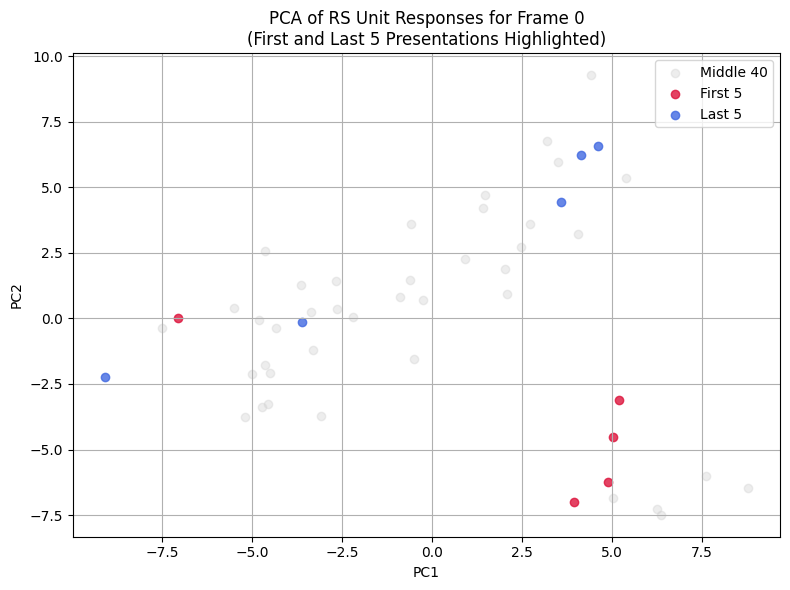

In [82]:
# Rebuild stim_table and frame_0_ids from previous context
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

stim_table = oursession.get_stimulus_table('natural_scenes')
frame_0_ids = stim_table[stim_table['frame'] == 0].index.tolist()

# initialize matrix (50 presentations x 249 neurons)
n_presentations = len(frame_0_ids)
n_neurons = len(RS_units_filtered)
presentation_matrix = np.zeros((n_presentations, n_neurons), dtype=int)

# fill the matrix
stim_id_to_row = {stim_id: i for i, stim_id in enumerate(frame_0_ids)}
unit_id_to_col = {unit_id: j for j, unit_id in enumerate(RS_units_filtered)}

filtered_spikes = confident_rs_spk[
    (confident_rs_spk['stimulus_presentation_id'].isin(frame_0_ids)) &
    (confident_rs_spk['unit_id'].isin(RS_units_filtered))
]

for row in filtered_spikes.itertuples():
    pres_idx = stim_id_to_row[row.stimulus_presentation_id]
    unit_idx = unit_id_to_col[row.unit_id]
    presentation_matrix[pres_idx, unit_idx] += 1

# pCA
X_scaled = StandardScaler().fit_transform(presentation_matrix)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# first 5, last 5, and middle presentation indices
first5 = np.arange(5)
last5 = np.arange(45, 50)
middle = np.setdiff1d(np.arange(50), np.concatenate([first5, last5]))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[middle, 0], X_pca[middle, 1], color='lightgray', label='Middle 40', alpha=0.4)
plt.scatter(X_pca[first5, 0], X_pca[first5, 1], color='crimson', label='First 5', alpha=0.8)
plt.scatter(X_pca[last5, 0], X_pca[last5, 1], color='royalblue', label='Last 5', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Unit Responses for Frame 0\n(First and Last 5 Presentations Highlighted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

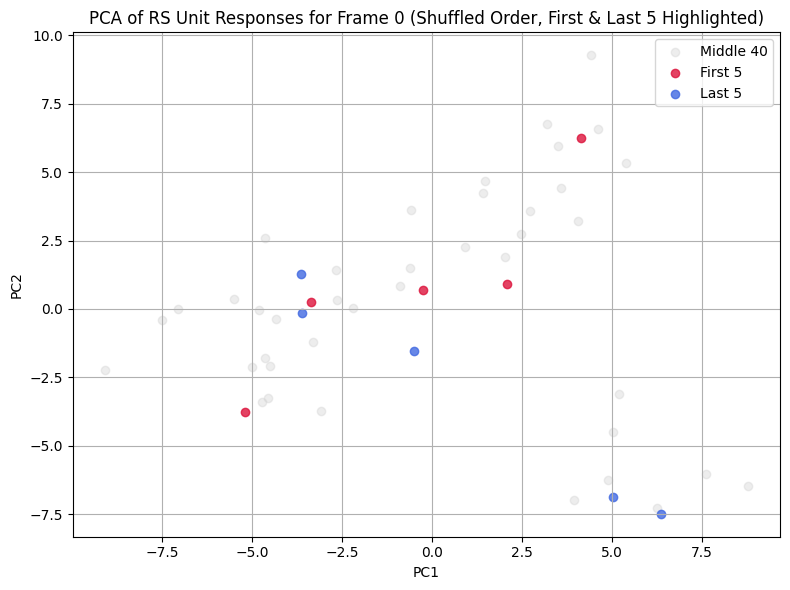

In [83]:
# Proceed after stim_table and spike matrix setup
# Reconstruct presentation_matrix as before
frame_0_ids = stim_table[stim_table['frame'] == 0].index.tolist()

n_presentations = len(frame_0_ids)
n_neurons = len(RS_units_filtered)
presentation_matrix = np.zeros((n_presentations, n_neurons), dtype=int)

stim_id_to_row = {stim_id: i for i, stim_id in enumerate(frame_0_ids)}
unit_id_to_col = {unit_id: j for j, unit_id in enumerate(RS_units_filtered)}

filtered_spikes = confident_rs_spk[
    (confident_rs_spk['stimulus_presentation_id'].isin(frame_0_ids)) &
    (confident_rs_spk['unit_id'].isin(RS_units_filtered))
]

for row in filtered_spikes.itertuples():
    pres_idx = stim_id_to_row[row.stimulus_presentation_id]
    unit_idx = unit_id_to_col[row.unit_id]
    presentation_matrix[pres_idx, unit_idx] += 1

# shuffle the row order (presentation order)
shuffled_indices = np.random.permutation(n_presentations)
presentation_matrix_shuffled = presentation_matrix[shuffled_indices]

#  PCA
X_scaled_shuffled = StandardScaler().fit_transform(presentation_matrix_shuffled)
X_pca_shuffled = PCA(n_components=2).fit_transform(X_scaled_shuffled)

# Redefine first 5, last 5, and middle 40 indices 
first5 = shuffled_indices[:5]
last5 = shuffled_indices[-5:]
middle = np.setdiff1d(shuffled_indices, np.concatenate((first5, last5)))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_shuffled[middle, 0], X_pca_shuffled[middle, 1], color='lightgray', label='Middle 40', alpha=0.4)
plt.scatter(X_pca_shuffled[first5, 0], X_pca_shuffled[first5, 1], color='crimson', label='First 5', alpha=0.8)
plt.scatter(X_pca_shuffled[last5, 0], X_pca_shuffled[last5, 1], color='royalblue', label='Last 5', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Unit Responses for Frame 0 (Shuffled Order, First & Last 5 Highlighted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Population coding approach — treating the ensemble of neurons as a single high-dimensional vector, and studying how their joint activity evolves over time as the stimulus is repeated.
 Concept : Neurons as a Vector
Each presentation of the same stimulus (e.g. image frame=1) is shown repeatedly - 50 times.
For each presentation, you measure the #of spikes in RS_units_filtered.
This gives you a 249D vector (if there are 249 neurons).
So you get a matrix:
Shape = [# of repetitions × # of neurons] = 50 × 249
Then:
Compare early presentations (first 10 rows) vs. late presentations (last 10 rows)
Use Euclidean distance, cosine distance, or PCA/UMAP to see if population activity shifts over time.
This reveals whether the population encoding of the same image drifts due to adaptation or plasticity.

# Adaptation effects on selected neurons for all frames with PCA 

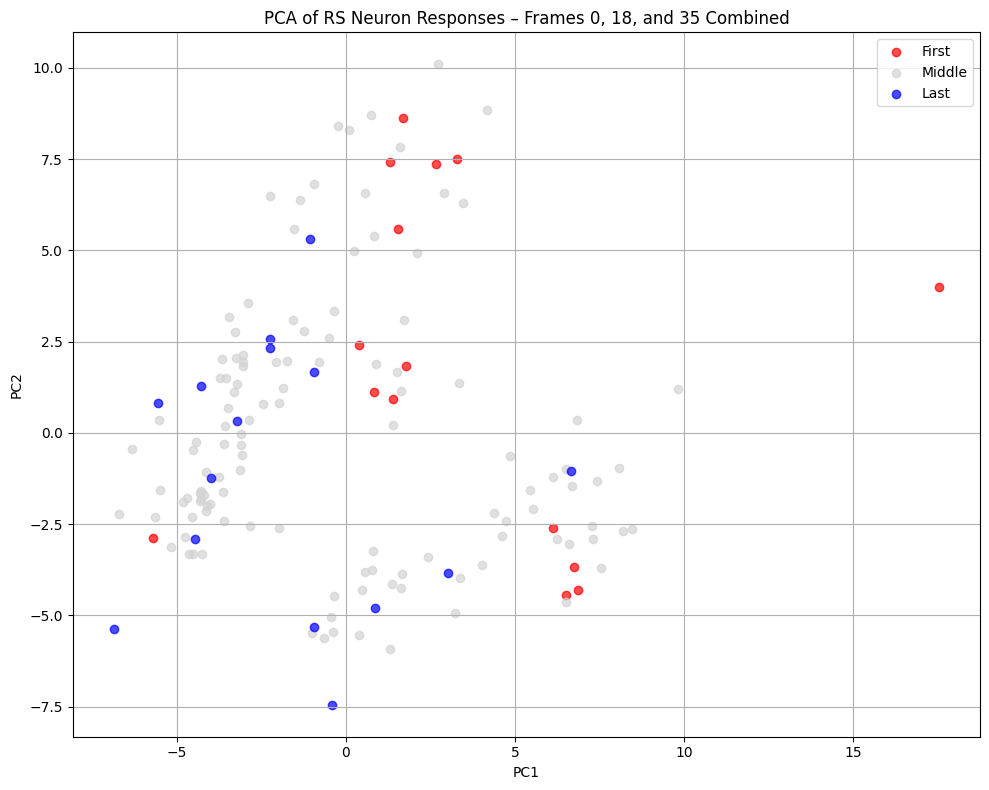

In [84]:
# Select frames to analyze
frames_to_check = [0, 18, 35]

all_vectors = []
all_labels = []  # 'first', 'last', or 'middle'
all_colors = []

for frame in frames_to_check:
    # get the 50 presentation IDs for this frame
    frame_ids = stim_table[stim_table['frame'] == frame].index.tolist()
    
    # initialize matrix for this frame
    matrix = np.zeros((50, len(RS_units_filtered)), dtype=int)
    
    # build map for indexing
    stim_to_row = {sid: i for i, sid in enumerate(frame_ids)}
    unit_to_col = {uid: j for j, uid in enumerate(RS_units_filtered)}
    
    # filter spikes for this frame
    filtered = confident_rs_spk[
        (confident_rs_spk['stimulus_presentation_id'].isin(frame_ids)) &
        (confident_rs_spk['unit_id'].isin(RS_units_filtered))
    ]
    
    # fill the matrix
    for row in filtered.itertuples():
        r = stim_to_row[row.stimulus_presentation_id]
        c = unit_to_col[row.unit_id]
        matrix[r, c] += 1

    # append data
    all_vectors.append(matrix)
    all_labels += ['first'] * 5 + ['middle'] * 40 + ['last'] * 5
    all_colors += ['red'] * 5 + ['gray'] * 40 + ['blue'] * 5

# stack and run PCA on full 150x249 matrix
combined_matrix = np.vstack(all_vectors)
X_scaled = StandardScaler().fit_transform(combined_matrix)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for label, color in zip(['first', 'middle', 'last'], ['red', 'lightgray', 'blue']):
    idxs = [i for i, lab in enumerate(all_labels) if lab == label]
    plt.scatter(X_pca[idxs, 0], X_pca[idxs, 1], label=label.capitalize(), color=color, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Neuron Responses – Frames 0, 18, and 35 Combined")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

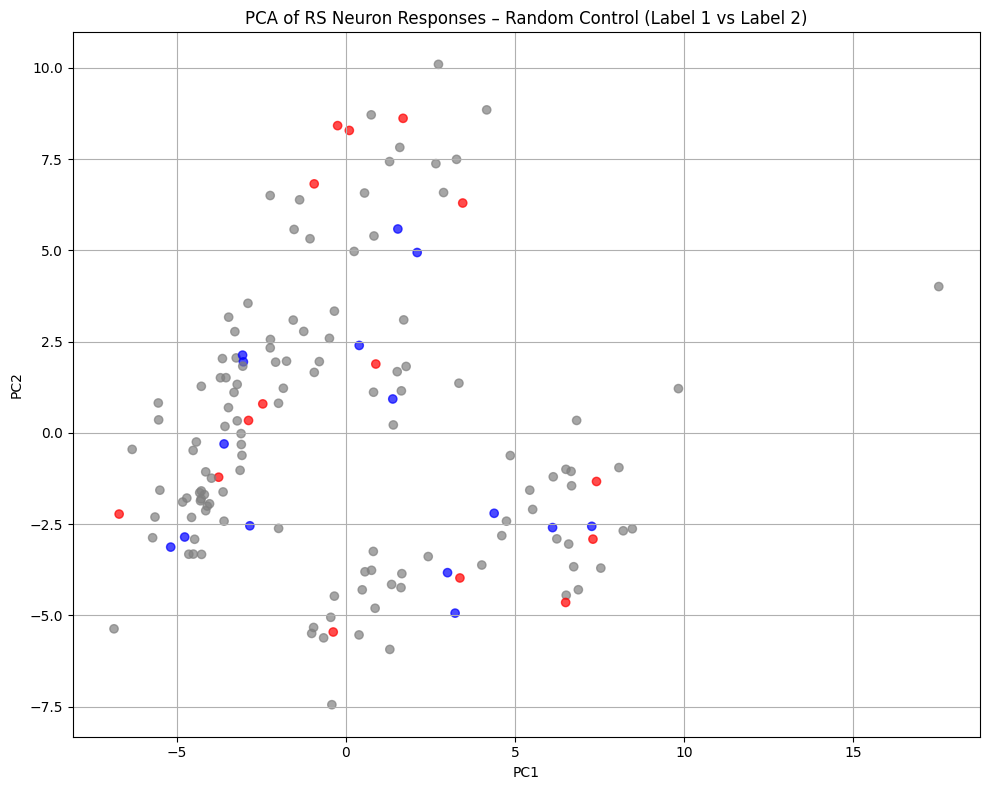

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# reinitialize variables
frames_to_check = [0, 18, 35]
all_vectors = []
all_labels = []

# track absolute indices of random selections
label1_indices = []
label2_indices = []

start_idx = 0

for frame in frames_to_check:
    # get the 50 presentation IDs for this frame
    frame_ids = stim_table[stim_table['frame'] == frame].index.tolist()
    
    # initialize matrix for this frame
    matrix = np.zeros((50, len(RS_units_filtered)), dtype=int)
    
    # build indexing maps
    stim_to_row = {sid: i for i, sid in enumerate(frame_ids)}
    unit_to_col = {uid: j for j, uid in enumerate(RS_units_filtered)}
    
    # filter spike data
    filtered = confident_rs_spk[
        (confident_rs_spk['stimulus_presentation_id'].isin(frame_ids)) &
        (confident_rs_spk['unit_id'].isin(RS_units_filtered))
    ]
    
    for row in filtered.itertuples():
        r = stim_to_row[row.stimulus_presentation_id]
        c = unit_to_col[row.unit_id]
        matrix[r, c] += 1

    all_vectors.append(matrix)

    # random selection of 5 + 5 unique indices
    rand_indices = np.random.choice(50, size=10, replace=False)
    label1_local = rand_indices[:5]
    label2_local = rand_indices[5:]

    label1_indices.extend(start_idx + label1_local)
    label2_indices.extend(start_idx + label2_local)

    # fill placeholder labels for 50 presentations (used only for index tracking)
    all_labels += ['middle'] * 50
    start_idx += 50

# stack all data and run PCA
combined_matrix = np.vstack(all_vectors)
X_scaled = StandardScaler().fit_transform(combined_matrix)
X_pca = PCA(n_components=2).fit_transform(X_scaled)

colors = ['gray'] * len(all_labels)
for idx in label1_indices:
    colors[idx] = 'red'
for idx in label2_indices:
    colors[idx] = 'blue'

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Neuron Responses – Random Control (Label 1 vs Label 2)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Adaptation effects on on selected neurons for frame 18(increasing frequency)

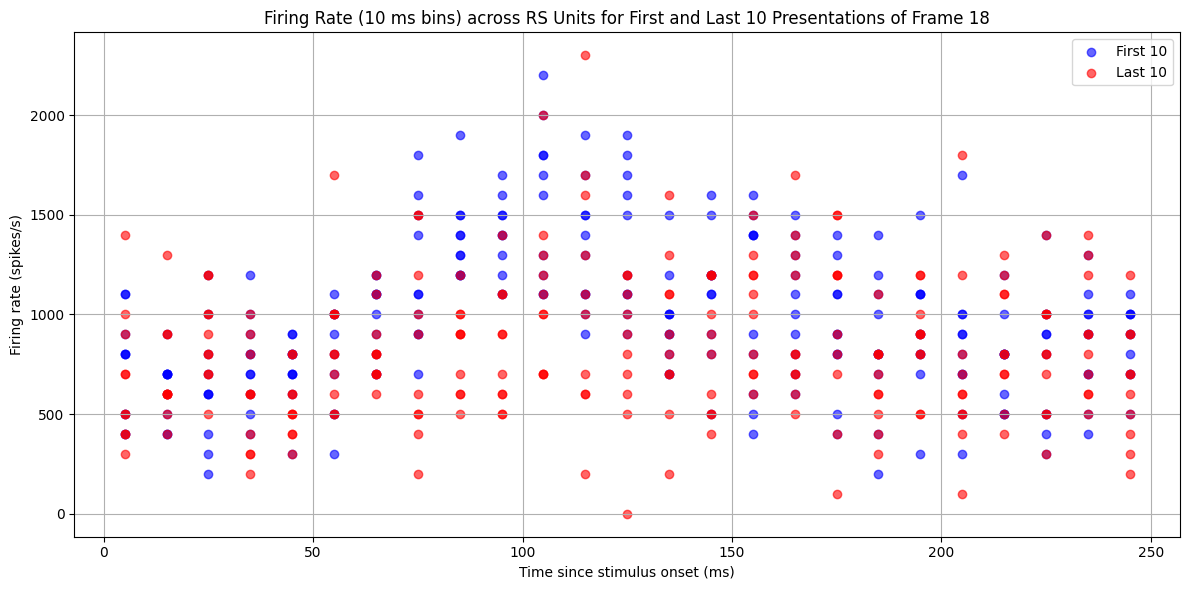

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# define binning parameters
bin_edges = np.arange(0, 0.250 + 0.010, 0.010)  # from 0 to 250 ms in 10 ms steps
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = 0.010  # 10 ms in seconds

# filter spikes to only RS_units_filtered
rs_spikes = confident_rs_spk[confident_rs_spk['unit_id'].isin(RS_units_filtered)]

# get presentation IDs for frame 18
frame_18_ids = stim_table[stim_table['frame'] == 18].index.tolist()
first10_ids_f18 = frame_18_ids[:10]
last10_ids_f18 = frame_18_ids[-10:]

# function to compute spike count across all RS units for a given presentation
def compute_total_firing_rate(pres_id):
    spike_times = rs_spikes[rs_spikes['stimulus_presentation_id'] == pres_id]['time_since_stimulus_presentation_onset']
    counts, _ = np.histogram(spike_times, bins=bin_edges)
    return counts / bin_width  # convert to spikes/sec (firing rate)

plt.figure(figsize=(12, 6))

for i, pres_id in enumerate(first10_ids_f18 + last10_ids_f18):
    firing_rate = compute_total_firing_rate(pres_id)
    color = 'blue' if i < 10 else 'red'
    label = 'First 10' if i == 0 else ('Last 10' if i == 10 else None)
    plt.scatter(bin_centers * 1000, firing_rate, color=color, alpha=0.6, label=label)

plt.xlabel("Time since stimulus onset (ms)")
plt.ylabel("Firing rate (spikes/s)")
plt.title("Firing Rate (10 ms bins) across RS Units for First and Last 10 Presentations of Frame 18")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

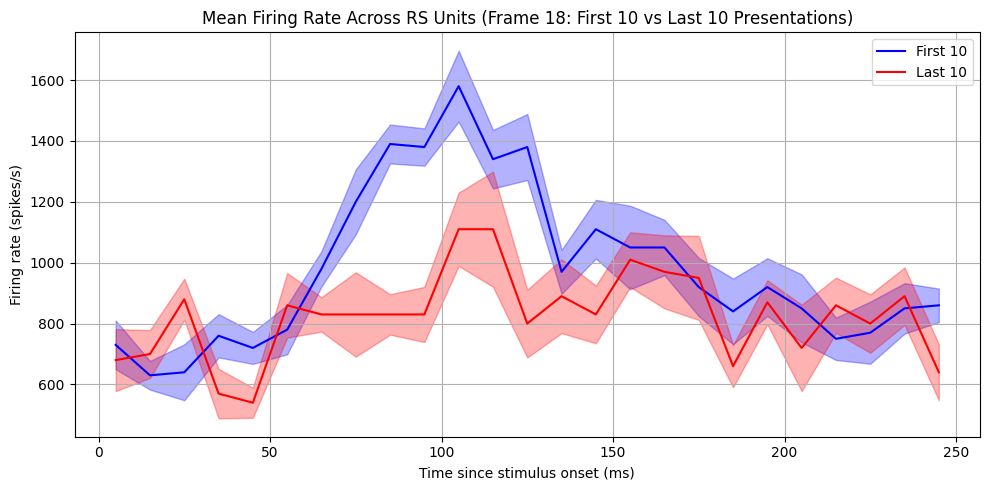

Ttest_indResult(statistic=2.434577877744217, pvalue=0.029308954532481262)

In [87]:
# assuming bin_edges, bin_centers, and bin_width are already defined
bin_edges = np.arange(0, 0.250 + 0.010, 0.010)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = 0.010  # 10 ms

# extract frame 18 presentation IDs
frame18_ids = stim_table[stim_table['frame'] == 18].index.tolist()
first10_ids_18 = frame18_ids[:10]
last10_ids_18 = frame18_ids[-10:]

# filter RS spikes
rs_spikes = confident_rs_spk[confident_rs_spk['unit_id'].isin(RS_units_filtered)]

# compute binned firing rates for a list of presentation IDs
def get_firing_matrix(pres_ids):
    firing_matrix = []
    for pid in pres_ids:
        spike_times = rs_spikes[rs_spikes['stimulus_presentation_id'] == pid]['time_since_stimulus_presentation_onset']
        counts, _ = np.histogram(spike_times, bins=bin_edges)
        firing_matrix.append(counts / bin_width)  # convert to spikes/sec
    return np.array(firing_matrix)  # shape: (n_pres, n_bins)

# get binned firing rates
first10_matrix_18 = get_firing_matrix(first10_ids_18)
last10_matrix_18 = get_firing_matrix(last10_ids_18)

# compute means and SEM
first10_mean_18 = first10_matrix_18.mean(axis=0)
last10_mean_18 = last10_matrix_18.mean(axis=0)

first10_sem_18 = first10_matrix_18.std(axis=0) / np.sqrt(first10_matrix_18.shape[0])
last10_sem_18 = last10_matrix_18.std(axis=0) / np.sqrt(last10_matrix_18.shape[0])

# plot mean ± SEM
plt.figure(figsize=(10, 5))
plt.plot(bin_centers * 1000, first10_mean_18, color='blue', label='First 10')
plt.fill_between(bin_centers * 1000, first10_mean_18 - first10_sem_18, first10_mean_18 + first10_sem_18, color='blue', alpha=0.3)
plt.plot(bin_centers * 1000, last10_mean_18, color='red', label='Last 10')
plt.fill_between(bin_centers * 1000, last10_mean_18 - last10_sem_18, last10_mean_18 + last10_sem_18, color='red', alpha=0.3)
plt.xlabel("Time since stimulus onset (ms)")
plt.ylabel("Firing rate (spikes/s)")
plt.title("Mean Firing Rate Across RS Units (Frame 18: First 10 vs Last 10 Presentations)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

first10_total_18 = first10_matrix_18.sum(axis=1)
last10_total_18 = last10_matrix_18.sum(axis=1)

ttest_ind(first10_total_18, last10_total_18, equal_var=False)

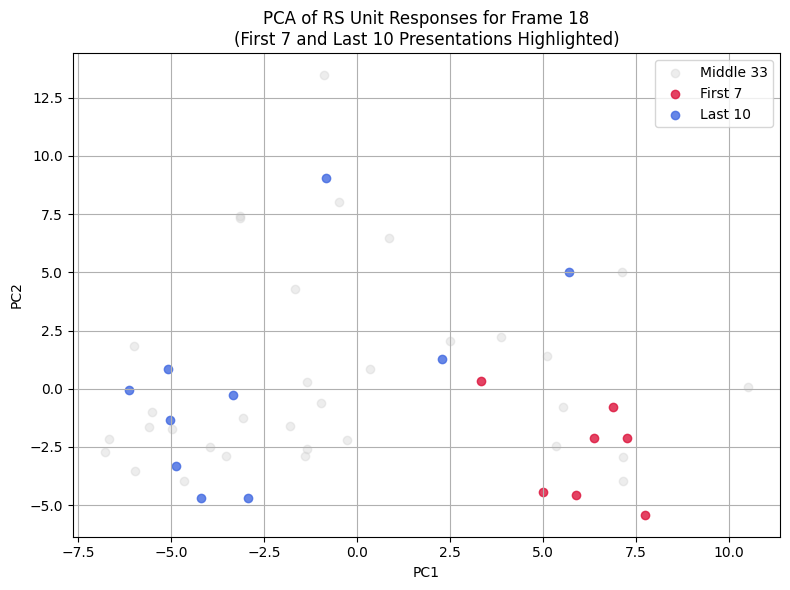

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# get the 50 presentation IDs for frame 18
frame_18_ids = stim_table[stim_table['frame'] == 18].index.tolist()

# initialize matrix (50 presentations x 249 neurons)
n_presentations_18 = len(frame_18_ids)
n_neurons = len(RS_units_filtered)
presentation_matrix_18 = np.zeros((n_presentations_18, n_neurons), dtype=int)

# build mapping for indexing
stim_id_to_row_18 = {stim_id: i for i, stim_id in enumerate(frame_18_ids)}
unit_id_to_col_18 = {unit_id: j for j, unit_id in enumerate(RS_units_filtered)}

# filter spikes
filtered_spikes_18 = confident_rs_spk[
    (confident_rs_spk['stimulus_presentation_id'].isin(frame_18_ids)) &
    (confident_rs_spk['unit_id'].isin(RS_units_filtered))
]

# fill the matrix
for row in filtered_spikes_18.itertuples():
    pres_idx = stim_id_to_row_18[row.stimulus_presentation_id]
    unit_idx = unit_id_to_col_18[row.unit_id]
    presentation_matrix_18[pres_idx, unit_idx] += 1

# PCA
X_scaled_18 = StandardScaler().fit_transform(presentation_matrix_18)
X_pca_18 = PCA(n_components=2).fit_transform(X_scaled_18)

# Indices for plotting
first5_18 = np.arange(7)
last5_18 = np.arange(40, 50)
middle_18 = np.setdiff1d(np.arange(50), np.concatenate([first5_18, last5_18]))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_18[middle_18, 0], X_pca_18[middle_18, 1], color='lightgray', label='Middle 33', alpha=0.4)
plt.scatter(X_pca_18[first5_18, 0], X_pca_18[first5_18, 1], color='crimson', label='First 7', alpha=0.8)
plt.scatter(X_pca_18[last5_18, 0], X_pca_18[last5_18, 1], color='royalblue', label='Last 10', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Unit Responses for Frame 18\n(First 7 and Last 10 Presentations Highlighted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

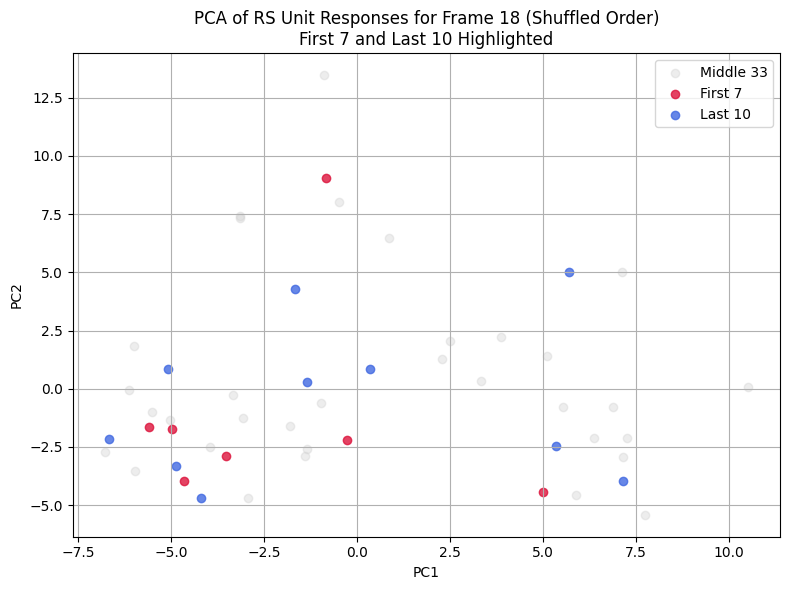

In [89]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# reuse the PCA matrix for frame 18
presentation_matrix_18 = presentation_matrix_18  # already constructed

# shuffle the presentation order (rows of the matrix)
shuffled_indices = np.random.permutation(presentation_matrix_18.shape[0])
shuffled_matrix = presentation_matrix_18[shuffled_indices]

# apply PCA to shuffled data
X_scaled_shuffled = StandardScaler().fit_transform(shuffled_matrix)
X_pca_shuffled = PCA(n_components=2).fit_transform(X_scaled_shuffled)

# identify which of the shuffled rows correspond to the original first 5 and last 5
original_indices = np.argsort(shuffled_indices)
first5_shuffled = np.where(original_indices < 7)[0]
last5_shuffled = np.where(original_indices >= 40)[0]
middle_shuffled = np.setdiff1d(np.arange(50), np.concatenate([first5_shuffled, last5_shuffled]))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_shuffled[middle_shuffled, 0], X_pca_shuffled[middle_shuffled, 1], color='lightgray', label='Middle 33', alpha=0.4)
plt.scatter(X_pca_shuffled[first5_shuffled, 0], X_pca_shuffled[first5_shuffled, 1], color='crimson', label='First 7', alpha=0.8)
plt.scatter(X_pca_shuffled[last5_shuffled, 0], X_pca_shuffled[last5_shuffled, 1], color='royalblue', label='Last 10', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Unit Responses for Frame 18 (Shuffled Order)\nFirst 7 and Last 10 Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Adaptation effects on on selected neurons for frame 35(decreasing frequency)

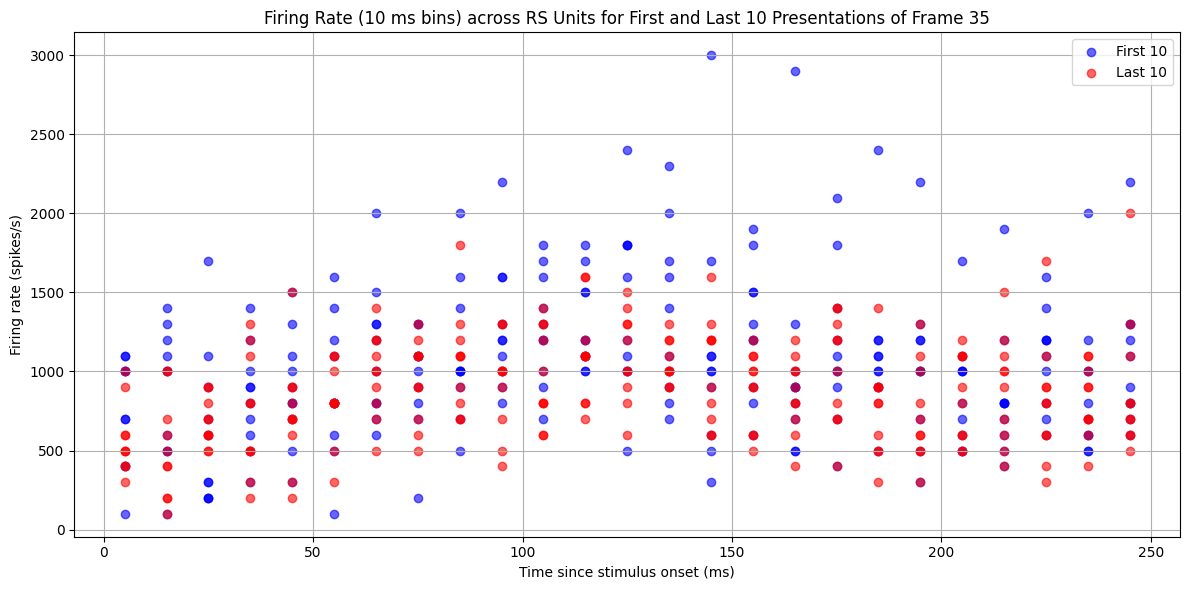

In [90]:


# define binning parameters
bin_edges = np.arange(0, 0.250 + 0.010, 0.010)  # from 0 to 250 ms in 10 ms steps
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = 0.010  # 10 ms in seconds


frame_35_ids = stim_table[stim_table['frame'] == 35].index.tolist()
first10_ids_f35 = frame_35_ids[:10]
last10_ids_f35 = frame_35_ids[-10:]

def compute_total_firing_rate_35(pres_id):
    spike_times = rs_spikes[rs_spikes['stimulus_presentation_id'] == pres_id]['time_since_stimulus_presentation_onset']
    counts, _ = np.histogram(spike_times, bins=bin_edges)
    return counts / bin_width  # convert to spikes/sec (firing rate)

plt.figure(figsize=(12, 6))

for i, pres_id in enumerate(first10_ids_f35 + last10_ids_f35):
    firing_rate = compute_total_firing_rate_35(pres_id)
    color = 'blue' if i < 10 else 'red'
    label = 'First 10' if i == 0 else ('Last 10' if i == 10 else None)
    plt.scatter(bin_centers * 1000, firing_rate, color=color, alpha=0.6, label=label)

plt.xlabel("Time since stimulus onset (ms)")
plt.ylabel("Firing rate (spikes/s)")
plt.title("Firing Rate (10 ms bins) across RS Units for First and Last 10 Presentations of Frame 35")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

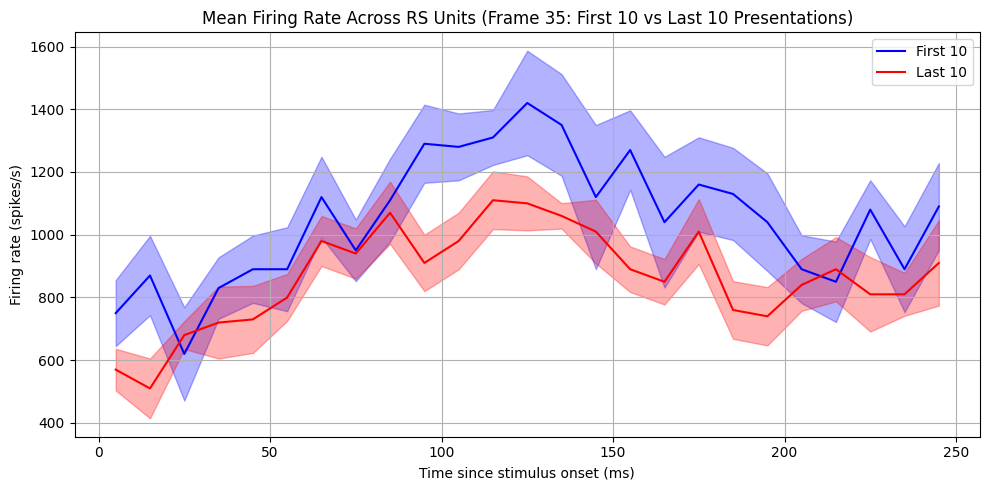

(1.7193474967599565, 0.11468124396950405)

In [91]:

from scipy.stats import ttest_ind

bin_edges = np.arange(0, 0.250 + 0.010, 0.010)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = 0.010  # 10 ms

frame35_ids = stim_table[stim_table['frame'] == 35].index.tolist()
first10_ids_35 = frame35_ids[:10]
last10_ids_35 = frame35_ids[-10:]

rs_spikes = confident_rs_spk[confident_rs_spk['unit_id'].isin(RS_units_filtered)]

def get_firing_matrix(pres_ids):
    firing_matrix = []
    for pid in pres_ids:
        spike_times = rs_spikes[rs_spikes['stimulus_presentation_id'] == pid]['time_since_stimulus_presentation_onset']
        counts, _ = np.histogram(spike_times, bins=bin_edges)
        firing_matrix.append(counts / bin_width)  # convert to spikes/sec
    return np.array(firing_matrix)  # shape: (n_pres, n_bins)

first10_matrix_35 = get_firing_matrix(first10_ids_35)
last10_matrix_35 = get_firing_matrix(last10_ids_35)

first10_mean_35 = first10_matrix_35.mean(axis=0)
last10_mean_35 = last10_matrix_35.mean(axis=0)

first10_sem_35 = first10_matrix_35.std(axis=0) / np.sqrt(first10_matrix_35.shape[0])
last10_sem_35 = last10_matrix_35.std(axis=0) / np.sqrt(last10_matrix_35.shape[0])

plt.figure(figsize=(10, 5))
plt.plot(bin_centers * 1000, first10_mean_35, color='blue', label='First 10')
plt.fill_between(bin_centers * 1000, first10_mean_35 - first10_sem_35, first10_mean_35 + first10_sem_35, color='blue', alpha=0.3)
plt.plot(bin_centers * 1000, last10_mean_35, color='red', label='Last 10')
plt.fill_between(bin_centers * 1000, last10_mean_35 - last10_sem_35, last10_mean_35 + last10_sem_35, color='red', alpha=0.3)
plt.xlabel("Time since stimulus onset (ms)")
plt.ylabel("Firing rate (spikes/s)")
plt.title("Mean Firing Rate Across RS Units (Frame 35: First 10 vs Last 10 Presentations)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

first10_total_35 = first10_matrix_35.sum(axis=1)
last10_total_35 = last10_matrix_35.sum(axis=1)

t_stat_35, p_val_35 = ttest_ind(first10_total_35, last10_total_35, equal_var=False)
t_stat_35, p_val_35

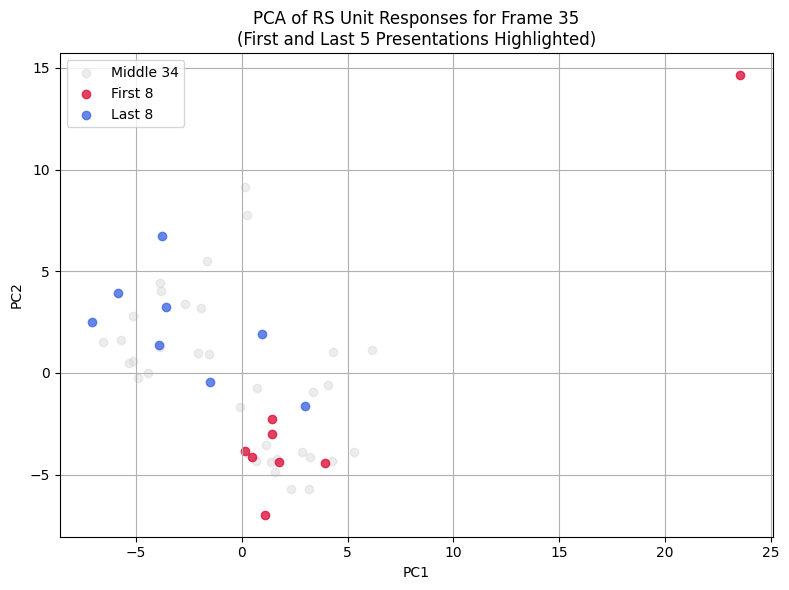

In [92]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

try:
    frame_35_ids = stim_table[stim_table['frame'] == 35].index.tolist()
except NameError:
    raise ValueError("stim_table is not defined. Please ensure it is available.")

# initialize matrix (50 presentations x number of RS units)
n_presentations_35 = len(frame_35_ids)
n_neurons = len(RS_units_filtered)
presentation_matrix_35 = np.zeros((n_presentations_35, n_neurons), dtype=int)

# build mapping for indexing
stim_id_to_row_35 = {stim_id: i for i, stim_id in enumerate(frame_35_ids)}
unit_id_to_col_35 = {unit_id: j for j, unit_id in enumerate(RS_units_filtered)}

# filter spikes
filtered_spikes_35 = confident_rs_spk[
    (confident_rs_spk['stimulus_presentation_id'].isin(frame_35_ids)) &
    (confident_rs_spk['unit_id'].isin(RS_units_filtered))
]

# fill the matrix
for row in filtered_spikes_35.itertuples():
    pres_idx = stim_id_to_row_35[row.stimulus_presentation_id]
    unit_idx = unit_id_to_col_35[row.unit_id]
    presentation_matrix_35[pres_idx, unit_idx] += 1

# PCA
X_scaled_35 = StandardScaler().fit_transform(presentation_matrix_35)
X_pca_35 = PCA(n_components=2).fit_transform(X_scaled_35)

first5_35 = np.arange(8)
last5_35 = np.arange(42, 50)
middle_35 = np.setdiff1d(np.arange(50), np.concatenate([first5_35, last5_35]))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_35[middle_35, 0], X_pca_35[middle_35, 1], color='lightgray', label='Middle 34', alpha=0.4)
plt.scatter(X_pca_35[first5_35, 0], X_pca_35[first5_35, 1], color='crimson', label='First 8', alpha=0.8)
plt.scatter(X_pca_35[last5_35, 0], X_pca_35[last5_35, 1], color='royalblue', label='Last 8', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Unit Responses for Frame 35\n(First and Last 5 Presentations Highlighted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

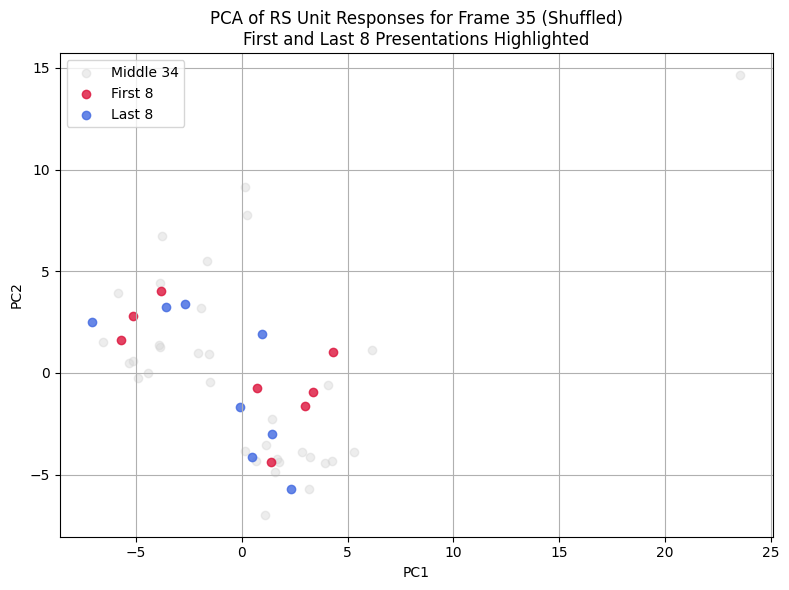

In [93]:
# shuffle the rows of the presentation matrix for Frame 35
shuffled_indices_35 = np.random.permutation(presentation_matrix_35.shape[0])
shuffled_matrix_35 = presentation_matrix_35[shuffled_indices_35]

# apply PCA to the shuffled matrix
X_scaled_shuffled_35 = StandardScaler().fit_transform(shuffled_matrix_35)
X_pca_shuffled_35 = PCA(n_components=2).fit_transform(X_scaled_shuffled_35)

# recover the original indices to find which shuffled rows correspond to first and last
original_indices_35 = np.argsort(shuffled_indices_35)
first8_shuffled = np.where(original_indices_35 < 8)[0]
last8_shuffled = np.where(original_indices_35 >= 42)[0]
middle_shuffled = np.setdiff1d(np.arange(50), np.concatenate([first8_shuffled, last8_shuffled]))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_shuffled_35[middle_shuffled, 0], X_pca_shuffled_35[middle_shuffled, 1], color='lightgray', label='Middle 34', alpha=0.4)
plt.scatter(X_pca_shuffled_35[first8_shuffled, 0], X_pca_shuffled_35[first8_shuffled, 1], color='crimson', label='First 8', alpha=0.8)
plt.scatter(X_pca_shuffled_35[last8_shuffled, 0], X_pca_shuffled_35[last8_shuffled, 1], color='royalblue', label='Last 8', alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of RS Unit Responses for Frame 35 (Shuffled)\nFirst and Last 8 Presentations Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Adaptation effects on FS neurons for frame 18

In [94]:
ns_scenes_ids=oursession.get_stimulus_table('natural_scenes').index.values
confident_fs_spk=oursession.presentationwise_spike_times(stimulus_presentation_ids=ns_scenes_ids, unit_ids= confident_FS_neurons)
confident_fs_spk.head(10)    #confident_rs_spk - means confident RS neurons' presentation wise spike times 

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
5909.794764,51355,951097547,0.000318
5909.794821,51355,951116723,0.000375
5909.795921,51355,951116716,0.001475
5909.796088,51355,951116826,0.001641
5909.796721,51355,951093080,0.002274
5909.797955,51355,951116768,0.003508
5909.798155,51355,951116476,0.003708
5909.799557,51355,951103632,0.005111
5909.799899,51355,951112712,0.005453


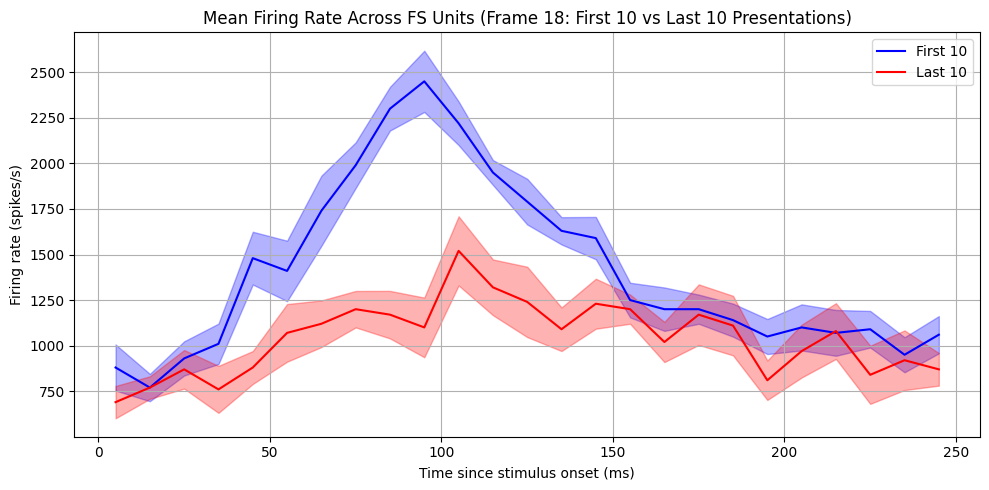

T-test result: t = 4.087, p = 0.00098


In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

bin_edges = np.arange(0, 0.250 + 0.010, 0.010)  # 0 to 250 ms in 10 ms steps
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = 0.010  # 10 ms

frame18_ids = stim_table[stim_table['frame'] == 18].index.tolist()
first10_ids_18 = frame18_ids[:10]
last10_ids_18 = frame18_ids[-10:]

fs_spikes = confident_fs_spk[confident_fs_spk['unit_id'].isin(confident_FS_neurons)]

def get_firing_matrix(pres_ids):
    firing_matrix = []
    for pid in pres_ids:
        spike_times = fs_spikes[fs_spikes['stimulus_presentation_id'] == pid]['time_since_stimulus_presentation_onset']
        counts, _ = np.histogram(spike_times, bins=bin_edges)
        firing_matrix.append(counts / bin_width)  # spikes/sec
    return np.array(firing_matrix)

first10_matrix = get_firing_matrix(first10_ids_18)
last10_matrix = get_firing_matrix(last10_ids_18)

first10_mean = first10_matrix.mean(axis=0)
last10_mean = last10_matrix.mean(axis=0)
first10_sem = first10_matrix.std(axis=0) / np.sqrt(first10_matrix.shape[0])
last10_sem = last10_matrix.std(axis=0) / np.sqrt(last10_matrix.shape[0])

plt.figure(figsize=(10, 5))
plt.plot(bin_centers * 1000, first10_mean, color='blue', label='First 10')
plt.fill_between(bin_centers * 1000, first10_mean - first10_sem, first10_mean + first10_sem, color='blue', alpha=0.3)
plt.plot(bin_centers * 1000, last10_mean, color='red', label='Last 10')
plt.fill_between(bin_centers * 1000, last10_mean - last10_sem, last10_mean + last10_sem, color='red', alpha=0.3)
plt.xlabel("Time since stimulus onset (ms)")
plt.ylabel("Firing rate (spikes/s)")
plt.title("Mean Firing Rate Across FS Units (Frame 18: First 10 vs Last 10 Presentations)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

first10_total = first10_matrix.sum(axis=1)
last10_total = last10_matrix.sum(axis=1)

t_stat, p_val = ttest_ind(first10_total, last10_total, equal_var=False)
print(f"T-test result: t = {t_stat:.3f}, p = {p_val:.5f}")